# Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
from itertools import chain

from google.colab import drive

from pyspark import SparkConf, SparkContext, StorageLevel
from pyspark.sql import SparkSession, Row, functions as F
from pyspark.sql import types as T
from pyspark.sql.window import Window

from pyspark.sql.functions import (
    col, udf, when, expr, explode, row_number, collect_list, lit, concat_ws,
    lower, regexp_replace, create_map, length, trim, sum, max as spark_max
)
from pyspark.sql.types import FloatType, StringType

from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, VectorAssembler, Tokenizer, HashingTF, IDF,
    StopWordsRemover, Normalizer, StandardScaler, MinMaxScaler
)
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import (
    RandomForestClassifier, DecisionTreeClassifier,
    NaiveBayes, LogisticRegression
)

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Importing dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("najzeko/steam-reviews-2021")

print("Path to dataset files:", path)

100%|██████████| 2.97G/2.97G [00:35<00:00, 89.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/najzeko/steam-reviews-2021/versions/1


In [ ]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Steam Reviews Analysis") \
    .getOrCreate()

In [ ]:
# Path to the dataset folder
dataset_path = "/root/.cache/kagglehub/datasets/najzeko/steam-reviews-2021/versions/1"

# Identify the CSV file
file_path = f"{dataset_path}/steam_reviews.csv"

# Load the data into a PySpark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True, multiLine=True, escape='"')

# Show a sample of the data
df.show(5)
# "schinese" is "simple chinese", "tchinese" is "traditional chinese"

+---+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|_c0|app_id|            app_name|review_id|language|                            review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author.steamid|author.num_games_owned|author.num_reviews|author.playtime_forever|author.playtime_last_two_weeks|author.playtime_at_review|author.last_played|
+---+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-----

In the following analysis we take a sample of the dataset due to runtime errors we got, since our machines could not process the amount of the original dataset (21 million records). Our sample consists of only the English reviews, which are around 9 million, and is still considered to be a dataset suitable for Big Data.

In [ ]:
# Count number of english reviews
df.filter(df.language == "english").count()

In [ ]:
# create parquet with only engish reviews
df.filter(df.language == "english").write.parquet("sample_df", mode="overwrite")

In [ ]:
#sample_df = spark.read.parquet("/content/sample_df")  #read the parquet
sample_df = spark.read.parquet("sample_df.parquet")  #read the parquet

In [ ]:
#create new column with the length of each review
sample_df = sample_df.withColumn("review_length", length("review"))

In [ ]:
# view first rows of the sample dataframe
sample_df.show(5)

+---+------+--------------------+---------+--------+--------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+-------------+
|_c0|app_id|            app_name|review_id|language|              review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author.steamid|author.num_games_owned|author.num_reviews|author.playtime_forever|author.playtime_last_two_weeks|author.playtime_at_review|author.last_played|review_length|
+---+------+--------------------+---------+--------+--------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------

In [ ]:
# spark.catalog.clearCache() if PySpark cached an earlier version of the data and still reference outdated records

##  **Exploratory Data Analysis**

In [ ]:
# Rename the columns that have "." since we have errors in accessing them with their original name
sample_df = sample_df.withColumnRenamed("author.steamid", "author_steamid") \
                     .withColumnRenamed("author.num_games_owned", "author_num_games_owned") \
                     .withColumnRenamed("author.num_reviews", "author_num_reviews") \
                     .withColumnRenamed("author.playtime_forever", "author_playtime_forever") \
                     .withColumnRenamed("author.playtime_last_two_weeks", "author_playtime_last_two_weeks") \
                     .withColumnRenamed("author.playtime_at_review", "author_playtime_at_review") \
                     .withColumnRenamed("author.last_played", "author_last_played")

# Print the new column names
print(sample_df.columns)

['_c0', 'app_id', 'app_name', 'review_id', 'language', 'review', 'timestamp_created', 'timestamp_updated', 'recommended', 'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'author_steamid', 'author_num_games_owned', 'author_num_reviews', 'author_playtime_forever', 'author_playtime_last_two_weeks', 'author_playtime_at_review', 'author_last_played', 'review_length']


We observed that certain columns are not informative for our objective, therefore we decided to keep only the relevant features.

In [ ]:
# Keep only the relevant features
sample_df = sample_df.select("_c0","app_id","app_name","review_id","review","recommended","votes_helpful","steam_purchase","received_for_free","written_during_early_access","author_steamid", "author_num_games_owned", "author_num_reviews", "author_playtime_forever", "author_playtime_at_review", "review_length")

View the first records of our dataset to understand the data that we have.

In [ ]:
sample_df.show(5)

+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|_c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|
+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|  3|292030|The Witcher 3: Wi...| 85184605|One of the best R...|       true|            0|          true|            false|                      false|76561199054755373|   

Checking for null values and removing them.

In [ ]:
# Count nulls in each column
null_counts = sample_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in sample_df.columns])

# Display null counts for each column
null_counts.show()

+---+------+--------+---------+------+-----------+-------------+--------------+-----------------+---------------------------+--------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|_c0|app_id|app_name|review_id|review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|
+---+------+--------+---------+------+-----------+-------------+--------------+-----------------+---------------------------+--------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|  0|     0|       0|        0| 16750|          0|            0|             0|                0|                          0|             0|                     0|                 0|                      2|                    11847|        16750|
+---+------+

In [ ]:
# Drop rows with null values in any column
sample_df = sample_df.na.drop()

In [ ]:
# Verify no nulls remain
sample_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in sample_df.columns]).show()

+---+------+--------+---------+------+-----------+-------------+--------------+-----------------+---------------------------+--------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|_c0|app_id|app_name|review_id|review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|
+---+------+--------+---------+------+-----------+-------------+--------------+-----------------+---------------------------+--------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|  0|     0|       0|        0|     0|          0|            0|             0|                0|                          0|             0|                     0|                 0|                      0|                        0|            0|
+---+------+

Calculate summary statistics regarding the time (in minutes) that users played the game at the moment of writing their review. Using those, we will categorize users into three main categories, according to whether they have played for little, medium, or much time.

In [ ]:
 #basic stats of column
sample_df.select("author_playtime_at_review").describe().show()

+-------+-------------------------+
|summary|author_playtime_at_review|
+-------+-------------------------+
|  count|                  9606842|
|   mean|        9143.312766567828|
| stddev|        26478.30080684629|
|    min|                      1.0|
|    max|                3228103.0|
+-------+-------------------------+



Similarly, we calculate summary statistics regarding the total playtime of users and we will categorize them into three categories according to the amount of time they played games in total.

In [ ]:
sample_df.select("author_playtime_forever").describe().show()   #basic stats of column

+-------+-----------------------+
|summary|author_playtime_forever|
+-------+-----------------------+
|  count|                9606842|
|   mean|     16371.968813997357|
| stddev|      40908.99046628258|
|    min|                    0.0|
|    max|              3744943.0|
+-------+-----------------------+



In [ ]:
# Create new columns for playtime categories low medium and high for author playtimes
sample_df = sample_df.withColumn(
    "playtime_category",
    when(col("author_playtime_at_review") < 5000, "Low")
    .when((col("author_playtime_at_review") >= 5000) & (col("author_playtime_at_review") < 20000), "Medium")
    .otherwise("High")
)

sample_df = sample_df.withColumn(
    "playtime_forever_category",
    when(col("author_playtime_forever") < 5000, "Low")
    .when((col("author_playtime_forever") >= 5000) & (col("author_playtime_forever") < 20000), "Medium")
    .otherwise("High")
)

Use the aforementioned categories to visualize the number of users in each category, using barplots.

<Figure size 800x500 with 0 Axes>

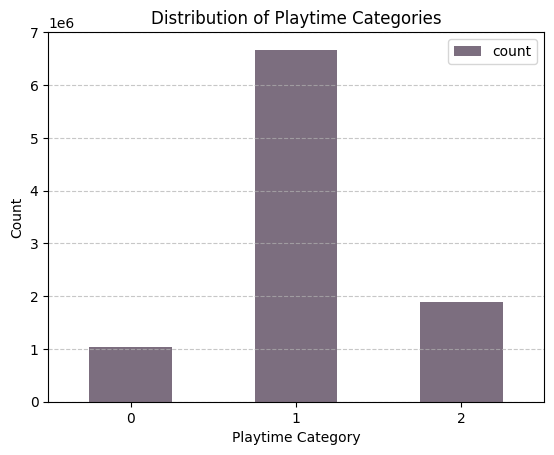

In [ ]:
# Count occurrences of each category using PySpark
category_counts_spark = sample_df.groupBy("playtime_category").count()

# Convert the result to Pandas - after the aggregations for better efficiency
category_counts_pandas = category_counts_spark.toPandas()

# Plot bar chart
plt.figure(figsize=(8, 5))
category_counts_pandas.plot(kind="bar", color=["#7C6E7F", "#FF9999", "#99CCFF"])
plt.title("Distribution of Playtime Categories")
plt.xlabel("Playtime Category")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

<Figure size 800x500 with 0 Axes>

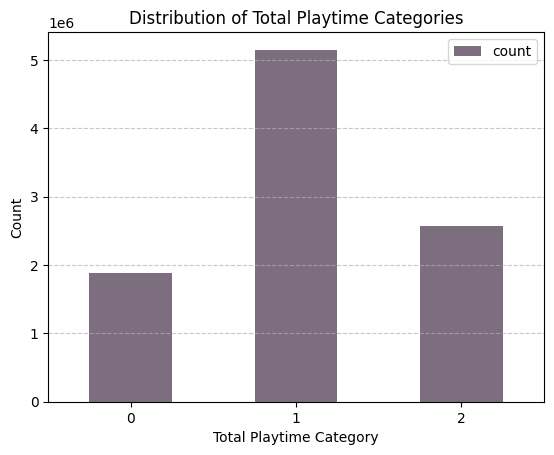

In [ ]:
# Count occurrences using PySpark
category_counts_forever_spark = sample_df.groupBy("playtime_forever_category").count()

# Convert to Pandas
category_counts_forever = category_counts_forever_spark.toPandas()

# Optional: Set index and sort to mimic value_counts() in Pandas
#category_counts_forever = category_counts_forever.set_index("playtime_forever_category").sort_values("count", ascending=False)


# Plot bar chart
plt.figure(figsize=(8, 5))
category_counts_forever.plot(kind="bar", color=["#7C6E7F", "#FF9999", "#99CCFF"])
plt.title("Distribution of Total Playtime Categories")
plt.xlabel("Total Playtime Category")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

Check all the unique games in the reviews.

In [ ]:
sample_df.select("app_name").distinct().show()

+--------------------+
|            app_name|
+--------------------+
|The Witcher 3: Wi...|
|    Dead by Daylight|
|Sid Meier's Civil...|
|            Portal 2|
|           Half-Life|
|Half-Life 2: Epis...|
|         Garry's Mod|
|           X Rebirth|
|Sid Meier's Civil...|
|Counter-Strike: S...|
|    Human: Fall Flat|
|      Umbrella Corps|
|Pogostuck: Rage W...|
|Momodora: Reverie...|
|         Down To One|
|                20XX|
|         Cold Waters|
|            NBA 2K18|
|      Super Meat Boy|
|            Identity|
+--------------------+
only showing top 20 rows



In [ ]:
#sort in desc order to find apps with many reviews
sample_df.groupBy("app_name").count().sort(col("count").desc()).show()

+--------------------+------+
|            app_name| count|
+--------------------+------+
|Tom Clancy's Rain...|370120|
|            Terraria|369444|
|         Garry's Mod|330738|
|  Grand Theft Auto V|318809|
|PLAYERUNKNOWN'S B...|317529|
|            Among Us|294755|
|                Rust|283140|
|       Rocket League|248067|
|            PAYDAY 2|186532|
|ARK: Survival Evo...|183892|
|      Stardew Valley|172208|
|The Elder Scrolls...|159849|
|The Witcher 3: Wi...|151121|
|    Dead by Daylight|143613|
|           Fallout 4|138737|
|        Phasmophobia|129364|
|        No Man's Sky|116023|
|       Hollow Knight|109372|
|            Portal 2|106638|
|Sid Meier's Civil...|103931|
+--------------------+------+
only showing top 20 rows



In [ ]:
#The following plot is not very interpretable, due to the large number of app names
'''
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = sample_df.groupBy("app_name").count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['app_name'].astype(str), pandas_df['count'])
plt.xticks(rotation=90)
plt.xlabel("App Name")
plt.ylabel("Count")
plt.title("App Name Counts Distribution")
plt.tight_layout()
plt.show()
'''

'\n# Convert Spark DataFrame to Pandas DataFrame\npandas_df = sample_df.groupBy("app_name").count().toPandas()\n\nplt.figure(figsize=(12, 6))\nplt.bar(pandas_df[\'app_name\'].astype(str), pandas_df[\'count\'])\nplt.xticks(rotation=90)\nplt.xlabel("App Name")\nplt.ylabel("Count")\nplt.title("App Name Counts Distribution")\nplt.tight_layout()\nplt.show()\n'

See how many users have purchased the app through Steam.

In [ ]:
sample_df.groupBy("steam_purchase").count().show()

+--------------+-------+
|steam_purchase|  count|
+--------------+-------+
|          true|7421733|
|         false|2185109|
+--------------+-------+



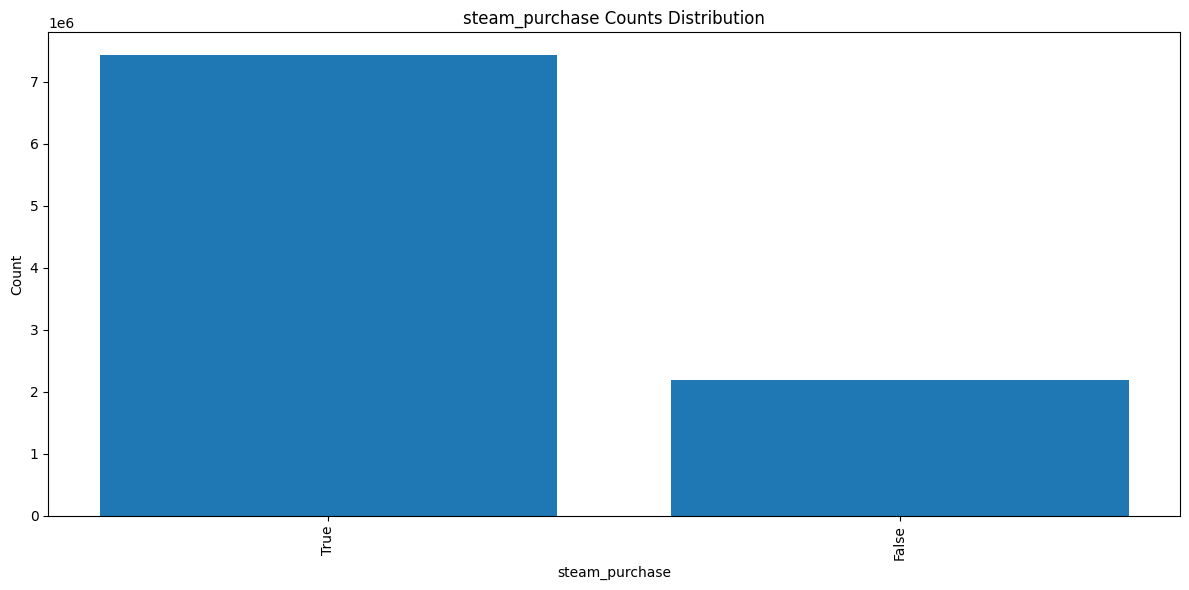

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame to plot distribution of steam purchase
pandas_df = sample_df.groupBy("steam_purchase").count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['steam_purchase'].astype(str), pandas_df['count'])
plt.xticks(rotation=90)
plt.xlabel("steam_purchase")
plt.ylabel("Count")
plt.title("steam_purchase Counts Distribution")
plt.tight_layout()
plt.show()


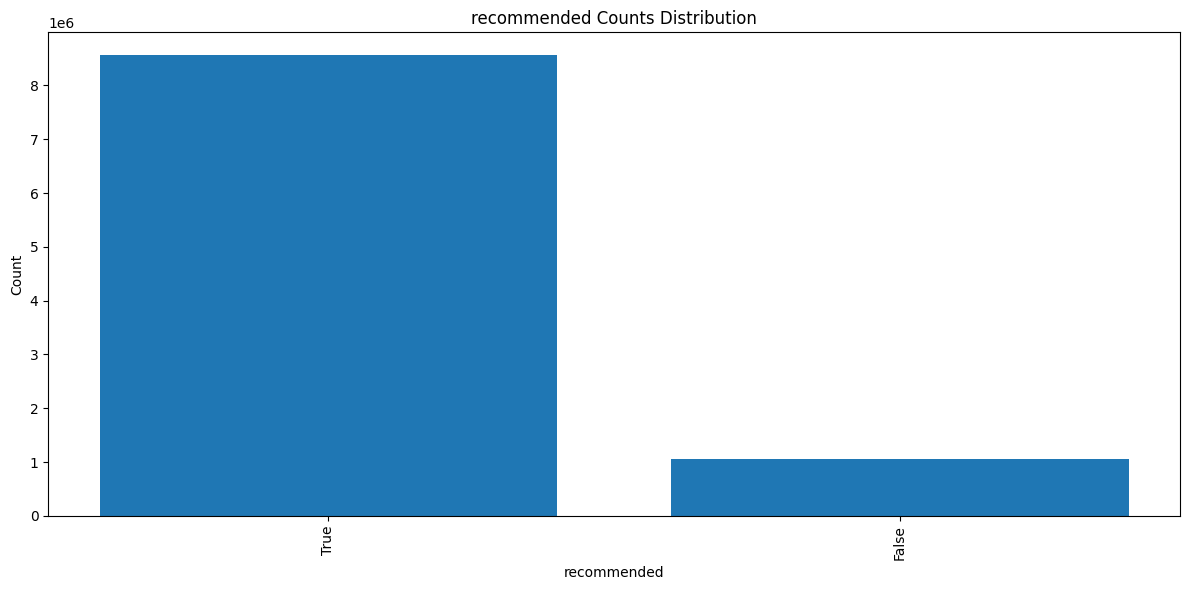

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame to plot distirbution of recommended col
pandas_df = sample_df.groupBy("recommended").count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['recommended'].astype(str), pandas_df['count'])
plt.xticks(rotation=90)
plt.xlabel("recommended")
plt.ylabel("Count")
plt.title("recommended Counts Distribution")
plt.tight_layout()
plt.show()


#we observe here that most reviews are positive - meaning they would recommend the app to other users

Check how many users have received the app for free.

In [ ]:
sample_df.groupBy("received_for_free").count().show()

+-----------------+-------+
|received_for_free|  count|
+-----------------+-------+
|             true| 278731|
|            false|9328111|
+-----------------+-------+



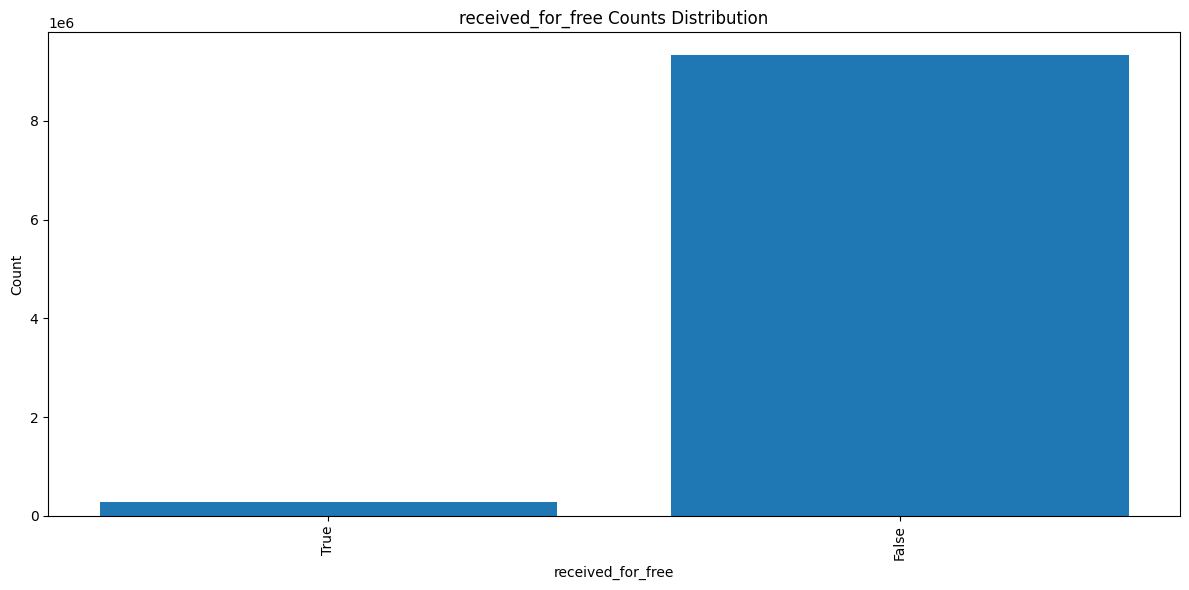

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame to plot distribution of recieved for free
pandas_df = sample_df.groupBy("received_for_free").count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['received_for_free'].astype(str), pandas_df['count'])
plt.xticks(rotation=90)
plt.xlabel("received_for_free")
plt.ylabel("Count")
plt.title("received_for_free Counts Distribution")
plt.tight_layout()
plt.show()

#most users did not receive the app for free

Check how many reiviews are written by users that purchased their app before the official release (early access).

In [ ]:
sample_df.groupBy("written_during_early_access").count().show()

+---------------------------+-------+
|written_during_early_access|  count|
+---------------------------+-------+
|                      false|8650199|
|                       true| 956643|
+---------------------------+-------+



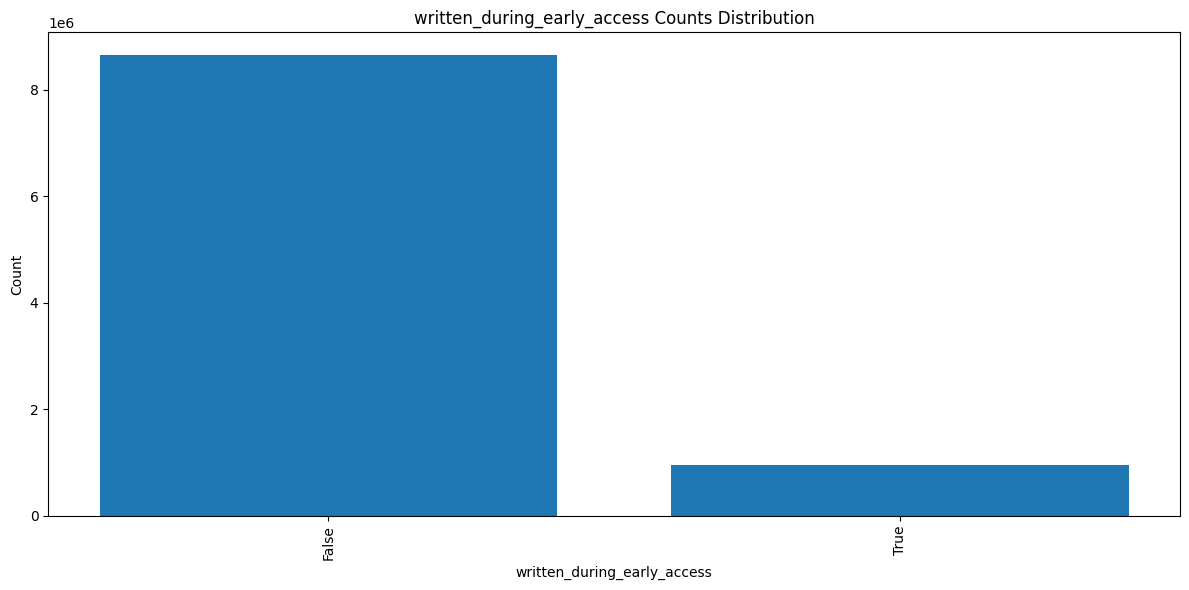

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame to plot distribution of written during early access
pandas_df = sample_df.groupBy("written_during_early_access").count().toPandas()

plt.figure(figsize=(12, 6))
plt.bar(pandas_df['written_during_early_access'].astype(str), pandas_df['count'])
plt.xticks(rotation=90)
plt.xlabel("written_during_early_access")
plt.ylabel("Count")
plt.title("written_during_early_access Counts Distribution")
plt.tight_layout()
plt.show()


In [ ]:
sample_df.groupBy("author_steamid").count().sort(col("count").desc()).show()   #sort in descending order to see the most frequent reviewers!

+-----------------+-----+
|   author_steamid|count|
+-----------------+-----+
|76561198062813911|  149|
|76561198315585536|  132|
|76561198045381877|  103|
|76561198064946151|  100|
|76561197969749884|   88|
|76561197997059777|   81|
|76561197990947284|   80|
|76561198048086581|   79|
|76561197999920602|   79|
|76561198166188807|   79|
|76561197970761123|   78|
|76561198011965365|   78|
|76561198038757354|   77|
|76561198112669681|   76|
|76561198094803808|   75|
|76561197986406741|   72|
|76561197999935168|   72|
|76561198057221241|   71|
|76561198266073876|   71|
|76561198082610824|   70|
+-----------------+-----+
only showing top 20 rows



# Bivariate analysis

We want to check if a user is more likely to recommend an app if they receive it for free

In [ ]:
# Calculate total reviews and recommended true counts
pivot_table = df.groupBy('received_for_free').agg(
    {'recommended': 'count'}
).withColumnRenamed('count(recommended)', 'Total Reviews')

recommended_true = df.filter(df['recommended'] == True).groupBy('received_for_free').count().withColumnRenamed('count', 'Recommended (True)')

# Join the two DataFrames
pivot_table = pivot_table.join(recommended_true, 'received_for_free', 'left_outer')

# Calculate proportion
pivot_table = pivot_table.withColumn('Proportion Recommended', pivot_table['Recommended (True)'] / pivot_table['Total Reviews'])

# Show results
pivot_table.show()

+-----------------+-------------+------------------+----------------------+
|received_for_free|Total Reviews|Recommended (True)|Proportion Recommended|
+-----------------+-------------+------------------+----------------------+
|             true|       688061|            611033|    0.8880506234185632|
|            false|     21059310|          18411577|    0.8742725663851285|
+-----------------+-------------+------------------+----------------------+



As shown in the above table, the proportion of users who recieved the apps for free and would recommend them is roughly equal to the proportion of users who did not receive the apps for free and would recommend them.

To see if longer reviews are more positive or negative

In [ ]:
# Calculate total reviews and recommended true counts for 'review_length'
pivot_table = sample_df.groupBy('review_length').agg(
    {'recommended': 'count'}
).withColumnRenamed('count(recommended)', 'Total Reviews')

recommended_true = sample_df.filter(sample_df['recommended'] == True).groupBy('review_length').count().withColumnRenamed('count', 'Recommended (True)')

# Join and calculate proportion
pivot_table = pivot_table.join(recommended_true, 'review_length', 'left_outer')
pivot_table = pivot_table.withColumn('Proportion Recommended', pivot_table['Recommended (True)'] / pivot_table['Total Reviews'])

# Show results
pivot_table.sort(col("review_length").desc()).show()  # to see longer reviews first




#NOTE: we can make a scatterplot of these values to check for correlation -- see cell below

+-------------+-------------+------------------+----------------------+
|review_length|Total Reviews|Recommended (True)|Proportion Recommended|
+-------------+-------------+------------------+----------------------+
|       150000|            1|              NULL|                  NULL|
|         8000|          862|               686|    0.7958236658932715|
|         7999|          300|               221|    0.7366666666666667|
|         7998|          134|                90|    0.6716417910447762|
|         7997|          119|                86|    0.7226890756302521|
|         7996|          117|                86|    0.7350427350427351|
|         7995|           68|                53|    0.7794117647058824|
|         7994|           89|                56|    0.6292134831460674|
|         7993|           65|                43|    0.6615384615384615|
|         7992|           68|                43|    0.6323529411764706|
|         7991|           65|                43|    0.6615384615

Are longer reviews more likely to recommend the app?

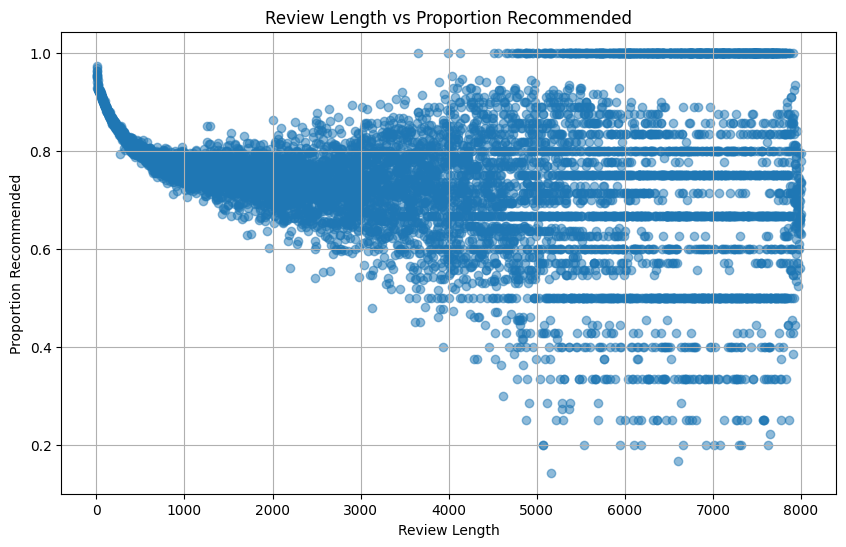

In [ ]:
# Convert Spark DataFrame to Pandas for visualization
pivot_table_pd = pivot_table.select('review_length', 'Proportion Recommended').toPandas()

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(pivot_table_pd['review_length'], pivot_table_pd['Proportion Recommended'], alpha=0.5)
plt.title('Review Length vs Proportion Recommended')
plt.xlabel('Review Length')
plt.ylabel('Proportion Recommended')
plt.grid(True)
plt.show()

Does higher playtime correlate with positive recommendations?

In [ ]:
# Calculate total reviews and recommended true counts for 'author_playtime_at_review'
pivot_table = sample_df.groupBy('author_playtime_at_review').agg(
    {'recommended': 'count'}
).withColumnRenamed('count(recommended)', 'Total Reviews')

recommended_true = sample_df.filter(sample_df['recommended'] == True).groupBy('author_playtime_at_review').count().withColumnRenamed('count', 'Recommended (True)')

# Join and calculate proportion
pivot_table = pivot_table.join(recommended_true, 'author_playtime_at_review', 'left_outer')
pivot_table = pivot_table.withColumn('Proportion Recommended', pivot_table['Recommended (True)'] / pivot_table['Total Reviews'])

# Show results
pivot_table.sort(col("author_playtime_at_review").desc()).show()  # to see people who played for longer first


+-------------------------+-------------+------------------+----------------------+
|author_playtime_at_review|Total Reviews|Recommended (True)|Proportion Recommended|
+-------------------------+-------------+------------------+----------------------+
|                3228103.0|            1|                 1|                   1.0|
|                3062784.0|            1|                 1|                   1.0|
|                2773429.0|            1|                 1|                   1.0|
|                2395854.0|            1|                 1|                   1.0|
|                2281002.0|            1|                 1|                   1.0|
|                2262933.0|            1|              NULL|                  NULL|
|                2213127.0|            1|                 1|                   1.0|
|                2172346.0|            1|                 1|                   1.0|
|                2071808.0|            1|                 1|                

Are players with higher playtimes more probable to recommend?

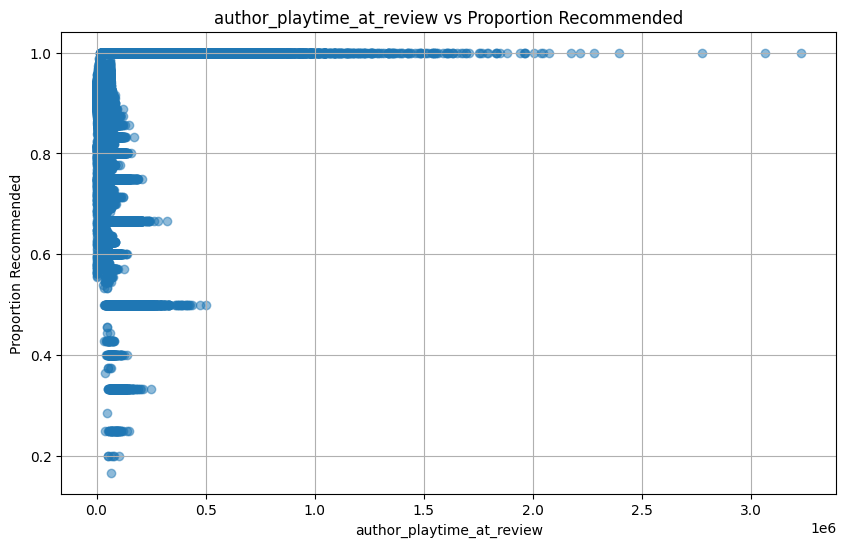

In [ ]:
# Convert Spark DataFrame to Pandas for visualization
pivot_table_pd = pivot_table.select('author_playtime_at_review', 'Proportion Recommended').toPandas()

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(pivot_table_pd['author_playtime_at_review'], pivot_table_pd['Proportion Recommended'], alpha=0.5)
plt.title('author_playtime_at_review vs Proportion Recommended')
plt.xlabel('author_playtime_at_review')
plt.ylabel('Proportion Recommended')
plt.grid(True)
plt.show()

Are frequent reviewers more positive or critical?

In [ ]:
# Calculate total reviews and recommended true counts for 'author_num_reviews'
pivot_table = sample_df.groupBy('author_num_reviews').agg(
    {'recommended': 'count'}
).withColumnRenamed('count(recommended)', 'Total Reviews')

recommended_true = sample_df.filter(sample_df['recommended'] == True).groupBy('author_num_reviews').count().withColumnRenamed('count', 'Recommended (True)')

# Join and calculate proportion
pivot_table = pivot_table.join(recommended_true, 'author_num_reviews', 'left_outer')
pivot_table = pivot_table.withColumn('Proportion Recommended', pivot_table['Recommended (True)'] / pivot_table['Total Reviews'])

# Show results
pivot_table.sort(col("author_num_reviews").desc()).show()  # to see people who have made more reviews first


+------------------+-------------+------------------+----------------------+
|author_num_reviews|Total Reviews|Recommended (True)|Proportion Recommended|
+------------------+-------------+------------------+----------------------+
|     4398046511105|            1|                 1|                   1.0|
|              5236|           15|                15|                   1.0|
|              4137|           49|                40|    0.8163265306122449|
|              3775|            5|                 3|                   0.6|
|              3774|            2|                 2|                   1.0|
|              3772|            4|                 4|                   1.0|
|              3767|            1|                 1|                   1.0|
|              3766|            4|                 4|                   1.0|
|              3764|            3|                 2|    0.6666666666666666|
|              3762|            2|                 2|                   1.0|

Are authors with more reviews more likely to recommend?

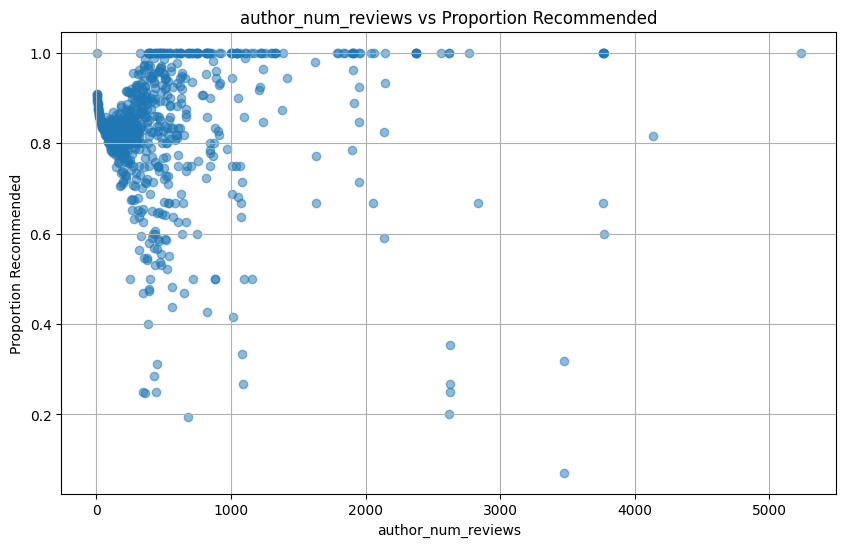

In [ ]:
# Cast to numeric (float or int) in Spark
pivot_table = pivot_table.withColumn("author_num_reviews", col("author_num_reviews").cast("int"))

# Convert to Pandas
pivot_table_pd = pivot_table.select('author_num_reviews', 'Proportion Recommended').toPandas()


# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(pivot_table_pd['author_num_reviews'], pivot_table_pd['Proportion Recommended'], alpha=0.5)
plt.title('author_num_reviews vs Proportion Recommended')
plt.xlabel('author_num_reviews')
plt.ylabel('Proportion Recommended')
plt.grid(True)
plt.show()

Of those that received the app for free, how many reccomend the app?

In [ ]:
df_pivot = sample_df.groupBy("received_for_free") \
    .pivot("recommended") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "recommended_true") \
    .withColumnRenamed("false", "recommended_false")

df_pivot.show()

+-----------------+-----------------+----------------+
|received_for_free|recommended_false|recommended_true|
+-----------------+-----------------+----------------+
|             true|            30837|          247894|
|            false|          1017382|         8310729|
+-----------------+-----------------+----------------+



Of all the apps that are being reviewed, how many were purchased on Steam?

In [ ]:
df_pivot = sample_df.groupBy("app_name") \
    .pivot("steam_purchase") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "steam_purchase_true") \
    .withColumnRenamed("false", "steam_purchase_false")

df_pivot.show()

+--------------------+--------------------+-------------------+
|            app_name|steam_purchase_false|steam_purchase_true|
+--------------------+--------------------+-------------------+
|    Human: Fall Flat|                8363|              16260|
|DRAGON BALL FighterZ|                4938|              11898|
|The Elder Scrolls...|               63504|              96345|
|      Umbrella Corps|                 743|                301|
|    Wallpaper Engine|                6634|              74055|
|          Nova Drift|                 359|               2132|
|           Detention|                 287|               1755|
|      SOULCALIBUR VI|                1727|               3287|
|The Witcher 3: Wi...|               13418|             137703|
|         GOD EATER 3|                 304|               1533|
|     Thief Simulator|                 183|               3387|
|The Legend of Her...|                 107|               1050|
|Ori and the Will ...|                 9

For each app, how many users have recommended it?

In [ ]:
df_pivot = sample_df.groupBy("app_name") \
    .pivot("recommended") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "recommended_true") \
    .withColumnRenamed("false", "recommended_false")

df_pivot.show()

+--------------------+-----------------+----------------+
|            app_name|recommended_false|recommended_true|
+--------------------+-----------------+----------------+
|    Human: Fall Flat|             1272|           23351|
|DRAGON BALL FighterZ|             1643|           15193|
|The Elder Scrolls...|            11616|          148233|
|      Umbrella Corps|              740|             304|
|    Wallpaper Engine|             1260|           79429|
|          Nova Drift|               41|            2450|
|           Detention|               71|            1971|
|      SOULCALIBUR VI|              910|            4104|
|The Witcher 3: Wi...|             3516|          147605|
|         GOD EATER 3|              214|            1623|
|     Thief Simulator|              480|            3090|
|The Legend of Her...|               43|            1114|
|Ori and the Will ...|              437|           13943|
|Danganronpa 2: Go...|              189|            7137|
|       STEINS

For each app, how many users have got it for free?

In [ ]:
df_pivot = sample_df.groupBy("app_name") \
    .pivot("received_for_free") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "received_for_free_true") \
    .withColumnRenamed("false", "received_for_free_false")

df_pivot.show()

+--------------------+-----------------------+----------------------+
|            app_name|received_for_free_false|received_for_free_true|
+--------------------+-----------------------+----------------------+
|    Human: Fall Flat|                  23632|                   991|
|DRAGON BALL FighterZ|                  16430|                   406|
|The Elder Scrolls...|                 158545|                  1304|
|      Umbrella Corps|                    956|                    88|
|    Wallpaper Engine|                  77949|                  2740|
|          Nova Drift|                   2327|                   164|
|           Detention|                   2011|                    31|
|      SOULCALIBUR VI|                   4948|                    66|
|The Witcher 3: Wi...|                 149426|                  1695|
|         GOD EATER 3|                   1801|                    36|
|     Thief Simulator|                   3473|                    97|
|The Legend of Her..

For each app, how many reviews have been written from users that had early access?

In [ ]:
df_pivot = sample_df.groupBy("app_name") \
    .pivot("written_during_early_access") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "written_during_early_access_true") \
    .withColumnRenamed("false", "written_during_early_access_false")

df_pivot.show()

+--------------------+---------------------------------+--------------------------------+
|            app_name|written_during_early_access_false|written_during_early_access_true|
+--------------------+---------------------------------+--------------------------------+
|    Human: Fall Flat|                            24623|                            NULL|
|DRAGON BALL FighterZ|                            16836|                            NULL|
|The Elder Scrolls...|                           159849|                            NULL|
|      Umbrella Corps|                             1044|                            NULL|
|    Wallpaper Engine|                            65517|                           15172|
|          Nova Drift|                             NULL|                            2491|
|           Detention|                             2042|                            NULL|
|      SOULCALIBUR VI|                             5014|                            NULL|
|The Witch

Of all the apps that have been purchased through Steam, how many are recommended?

In [ ]:
df_pivot = sample_df.groupBy("steam_purchase") \
    .pivot("recommended") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "recommended_true") \
    .withColumnRenamed("false", "recommended_false")

df_pivot.show()

+--------------+-----------------+----------------+
|steam_purchase|recommended_false|recommended_true|
+--------------+-----------------+----------------+
|          true|           784972|         6636761|
|         false|           263247|         1921862|
+--------------+-----------------+----------------+



How many apps did each user had early access on?


In [ ]:
df_pivot = sample_df.groupBy("author_steamid") \
    .pivot("written_during_early_access") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "written_during_early_access_true") \
    .withColumnRenamed("false", "written_during_early_access_false")

df_pivot.show()

+-----------------+---------------------------------+--------------------------------+
|   author_steamid|written_during_early_access_false|written_during_early_access_true|
+-----------------+---------------------------------+--------------------------------+
|76561197960269579|                                8|                               1|
|76561197960272407|                                5|                            NULL|
|76561197960272423|                                5|                               2|
|76561197960272973|                                3|                               1|
|76561197960275854|                                2|                               2|
|76561197960277107|                                1|                            NULL|
|76561197960279691|                                1|                            NULL|
|76561197960292122|                                1|                            NULL|
|76561197960297361|                        

For each For each category of the playtime (up to the day of the review), how many users have reccomended the apps of the review?

In [ ]:
df_pivot = sample_df.groupBy("playtime_category") \
    .pivot("recommended") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "recommended_true") \
    .withColumnRenamed("false", "recommended_false")

df_pivot.show()

+-----------------+-----------------+----------------+
|playtime_category|recommended_false|recommended_true|
+-----------------+-----------------+----------------+
|             High|           124420|          913725|
|              Low|           729851|         5942612|
|           Medium|           193948|         1702286|
+-----------------+-----------------+----------------+



For each category of the total playtime, how many users have reccomended the apps of the review?

In [ ]:
df_pivot = sample_df.groupBy("playtime_forever_category") \
    .pivot("recommended") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "recommended_true") \
    .withColumnRenamed("false", "recommended_false")

df_pivot.show()

+-------------------------+-----------------+----------------+
|playtime_forever_category|recommended_false|recommended_true|
+-------------------------+-----------------+----------------+
|                     High|           196750|         1685163|
|                      Low|           627187|         4522579|
|                   Medium|           224282|         2350881|
+-------------------------+-----------------+----------------+



Of the apps that have been purchased during early access, how many are recommended?

In [ ]:
df_pivot = sample_df.groupBy("written_during_early_access") \
    .pivot("recommended") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "recommended_true") \
    .withColumnRenamed("false", "recommended_false")

df_pivot.show()

+---------------------------+-----------------+----------------+
|written_during_early_access|recommended_false|recommended_true|
+---------------------------+-----------------+----------------+
|                       true|           130263|          826380|
|                      false|           917956|         7732243|
+---------------------------+-----------------+----------------+



For each category of number of games owned, how many apps are recommended?

In [ ]:
df_pivot = sample_df.groupBy("author_num_games_owned") \
    .pivot("recommended") \
    .agg(F.count("*")) \
    .withColumnRenamed("true", "recommended_true") \
    .withColumnRenamed("false", "recommended_false")

df_pivot.show()

+----------------------+-----------------+----------------+
|author_num_games_owned|recommended_false|recommended_true|
+----------------------+-----------------+----------------+
|                    26|             5229|           60444|
|                  1677|               14|              86|
|                   474|              356|            1975|
|                  5385|             NULL|               6|
|                   964|               45|             330|
|                    29|             5228|           57980|
|                  2040|                7|              80|
|                  1806|                2|              19|
|                  2214|                7|              13|
|                  2927|                2|              24|
|                  1950|                1|              23|
|                  2250|             NULL|              24|
|                  3091|                1|               9|
|                  1697|                

# Recommendation System

In [ ]:
sample_df.show(10)

+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|_c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|
+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|  3|292030|The Witcher 3: Wi...| 85184605|One of the best R...|       true|            0|          true|            false|                      false|76561199054755373|   

Checking that recommended takes only true/false values

In [ ]:
sample_df.select("recommended").distinct().show()

+-----------+
|recommended|
+-----------+
|       true|
|      false|
+-----------+



In [ ]:
# Identify distribution in the 'recommended' column
sample_df.groupBy('recommended').count().show()

+-----------+-------+
|recommended|  count|
+-----------+-------+
|       true|8558623|
|      false|1048219|
+-----------+-------+



We observe a significant class imbalance (true: 8.58M and false: 1.05M) and hence, we proceed with 3% for Dominant Class & 10% for Minority Class (balanced reduction).


We tried using a stratified approach but the stratified df was returning 0 rows (.sampleBy() may fail if the specified fraction is too small to select records from a partition).

```python
# Define sampling fractions for each category
fractions = {"true": 0.03, "false": 0.10}  # Stratified sampling with balanced reduction

# Perform stratified sampling
stratified_sample = sample_df.sampleBy("recommended", fractions=fractions, seed=42)

# Show sampled data
stratified_sample.show(5)

# Count rows to verify sample size
print("Total Rows in Sample:", stratified_sample.count())
```

Hence, we proceeded with the sample() function.

In [ ]:
# Sample 5% for balanced speed and accuracy
sample_df2 = sample_df.sample(fraction=0.15, seed=42)

sample_df2.show(5)

+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|_c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|
+---+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+
| 24|292030|The Witcher 3: Wi...| 85178164|Isn't Geralt hot ...|       true|            0|          true|            false|                      false|76561198040150323|   

For faster read, we save this sample as a parquet file.

In [ ]:
# Save 2nd sample as a parquet for easier read
#sample_df2.write.parquet("sample_df2", mode="overwrite")

In [ ]:
# zip it because it is saved in multiple files
#!zip -r sample_df2.zip sample_df2
#from google.colab import files
#files.download("sample_df2.zip")

For faster reading of the dataset, mount from google drive.

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/My Drive/sample_df2.zip'

In [ ]:
import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('sample_df2_extracted')  # Target folder in Colab


In [ ]:
sample_df2 = spark.read.parquet("/content/sample_df2_extracted/sample_df2")

Taking a look at the dataset to ensure it is read properly.

In [ ]:
sample_df2.show(5)

+--------+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|     _c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|
+--------+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+
|15710073|306130|The Elder Scrolls...| 79519450|   Skyrim but online|       true|            3|          true|            false|                      false|7

In [ ]:
sample_df2.groupBy('recommended').count().show()

+-----------+-------+
|recommended|  count|
+-----------+-------+
|       true|1285737|
|      false| 156919|
+-----------+-------+



The target variable is not balanced in this new sample.

## Using a lexicon to generate a predicted rating based on review text and then performing ALS to generate recommendations

In [ ]:
!pip install vaderSentiment

analyzer = SentimentIntensityAnalyzer()
#if the review is null give sentiment 0 (as we saw earlier we didn't any null reviews though)
def get_compound_score(review):
    if review is None:
        return 0.0
    return float(analyzer.polarity_scores(review)['compound'])

# user defined function to find predicter rating
vader_udf = udf(get_compound_score, FloatType())

#apply udf to our df
sample_df2 = sample_df2.withColumn("sentiment_score", vader_udf(sample_df2["review"]))

# converting this value to a rating from 1 to 5  - this may not be necessary

from pyspark.sql.functions import col

sample_df2 = sample_df2.withColumn("rating",
    when(col("sentiment_score") >= 0.6, 5.0)
    .when((col("sentiment_score") >= 0.2) & (col("sentiment_score") < 0.6), 4.0)
    .when((col("sentiment_score") > -0.2) & (col("sentiment_score") < 0.2), 3.0)
    .when((col("sentiment_score") > -0.6) & (col("sentiment_score") <= -0.2), 2.0)
    .otherwise(1.0)
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
sample_df2.show()

+--------+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+---------------+------+
|     _c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|sentiment_score|rating|
+--------+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+---------------+------+
|15710073|306130|The Elder Scrolls...| 79519450|   Skyrim but online|       true|       

In [ ]:
sample_df2.select('rating').show(5)

+------+
|rating|
+------+
|   3.0|
|   4.0|
|   5.0|
|   5.0|
|   3.0|
+------+
only showing top 5 rows



Split into train and test datasets to proceed with ALS

In [ ]:
# Split into training and test sets (80/20 split)
(training_df, test_df) = sample_df2.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Save to Parquet (overwrite if it already exists)
training_df.write.mode("overwrite").parquet("/content/training_df.parquet")
test_df.write.mode("overwrite").parquet("/content/test_df.parquet")

In [ ]:
# Load back in a future session without recomputing splits
training_df = spark.read.parquet("/content/training_df.parquet")
test_df = spark.read.parquet("/content/test_df.parquet")

In [ ]:
training_df.show(5)

+-------+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+---------------+------+
|    _c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|sentiment_score|rating|
+-------+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+---------------+------+
|2274365|289070|Sid Meier's Civil...| 29700214|Been a fan of CIV...|       true|           

In [ ]:
test_df.show(5)

+-------+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+---------------+------+
|    _c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|sentiment_score|rating|
+-------+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+---------------+------+
|2274377|289070|Sid Meier's Civil...| 29688390|Almost 4 months a...|      false|           

In [ ]:
#prepare indexing to input properly in ALS
user_indexer = StringIndexer(inputCol="author_steamid", outputCol="userIndex", handleInvalid="keep")
item_indexer = StringIndexer(inputCol="app_id", outputCol="itemIndex", handleInvalid="keep")

# Fit indexers only on the training set
user_indexer_model = user_indexer.fit(training_df)
item_indexer_model = item_indexer.fit(training_df)

# Transform both train and test using the fitted models
training_df = user_indexer_model.transform(training_df)
training_df = item_indexer_model.transform(training_df)

test_df = user_indexer_model.transform(test_df)
test_df = item_indexer_model.transform(test_df)

# Save app_id labels for decoding later
app_id_labels = item_indexer_model.labels

We encountered an issue where the `StringIndexerModel` was trained only on the training set, so when we applied it to the test set, it failed to recognize userid's that appeared only in the test data. Since these unseen users were not part of the training set, the model didn’t know how to assign them an index. To prevent the process from crashing, we set the `handleInvalid` parameter to `"keep"` in the `StringIndexer`. This allows Spark to assign a special index, such as -1, to any unknown labels, ensuring the transformation continues smoothly even when new or unseen data is encountered.


In [ ]:
training_df.show(5)

+-------+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+---------------+------+---------+---------+
|    _c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|sentiment_score|rating|userIndex|itemIndex|
+-------+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+---------------+------+---------+---------+
|2274365|289070|Sid Meier's Civ

In [ ]:
test_df.show(5)

+-------+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+---------------+------+---------+---------+
|    _c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|sentiment_score|rating|userIndex|itemIndex|
+-------+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+---------------+------+---------+---------+
|2274377|289070|Sid Meier's Civ

We trained the ALS model with fewer iterations initially so it would run faster, but later increased the number of iterations and adjusted the settings because the predictions were falling out of bounds


In [ ]:
# Train ALS model - were fewer iterations so it runs faster, may increase it to get better results
# update: increased iterations and settings due to preds out of bounds

als = ALS(
    userCol="userIndex",
    itemCol="itemIndex",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=10,         # Reduce latent factors (default is 10)
    maxIter=5,      # Fewer iterations
    regParam=0.1   # Optional: Regularization
)
als_model = als.fit(training_df)



In [ ]:
# save to avoid out of memory errors and having to retrain
als_model.write().overwrite().save("/content/als_model")

Output the recommendations generated for a specific user. Notice that the output shows recommendations for a user outputing their userIndex and corresponding itemIndexes,  which is not the same as userid and appid's, we converted to userIndexes for ASL. However, we convert back to userid's and appid's in the next cells.

In [ ]:
# Get userIndex for a specific author_steamid
target_user_index = training_df.filter(col("author_steamid") == "76561198054022818") \
                              .select("userIndex").distinct().limit(1) \
                              .collect()[0]["userIndex"]

# Create a single-row DataFrame with this userIndex
user_id_df = spark.createDataFrame([(int(target_user_index),)], ["userIndex"])

# Get top 5 recommendations
user_recs = als_model.recommendForUserSubset(user_id_df, 5)

In [ ]:
user_recs.show(truncate=False)

+---------+----------------------------------------------------------------------------------+
|userIndex|recommendations                                                                   |
+---------+----------------------------------------------------------------------------------+
|52893    |[{296, 4.450095}, {3, 4.4363112}, {41, 4.426834}, {230, 4.054623}, {4, 3.9141245}]|
+---------+----------------------------------------------------------------------------------+



This means that the user with author_steamid 76561198054022818, was mapped to userindex 52893, and is recommended the item with itemindex 296 with a score (rating) of approx 4.45 etc.
We can find the recommendations and convert those itemindexes back to app ids
before printing, using the code below.

In [ ]:
# code below works better i think than next cell, utilizes code from pevious cell as well
rec_row = user_recs.collect()[0]

# Map back to original app_id
print("Recommended apps for user with author_steamid 76561198011462074:")
for rec in rec_row['recommendations']:
    item_index = rec['itemIndex']
    predicted_rating = rec['rating']
    original_app_id = app_id_labels[int(item_index)]
    print(f"App ID: {original_app_id}, Predicted Rating: {predicted_rating:.2f}")



Recommended apps for user with author_steamid 76561198011462074:
App ID: 502280, Predicted Rating: 4.45
App ID: 271590, Predicted Rating: 4.44
App ID: 48700, Predicted Rating: 4.43
App ID: 673950, Predicted Rating: 4.05
App ID: 578080, Predicted Rating: 3.91


Loading the model again due to repeated caching.

In [ ]:
als_model = ALSModel.load("/content/als_model")

In [ ]:
# Predict on subset
predictions = als_model.transform(test_df)

# Filter NaNs
predictions = predictions.filter(col("prediction").isNotNull()) # for coldstart problems

# Evaluate
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse:.4f}")

RMSE: 2.1454


We get a relatively large RMSE, given the range of our predictions. The model predicts out of bounds, as can be seen in the cells below.

In [ ]:
predictions.show(10)

+--------+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+---------------+------+---------+---------+----------+
|     _c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|sentiment_score|rating|userIndex|itemIndex|prediction|
+--------+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+---------------+------+---------+---------+-------

In [ ]:
max_pred = predictions.agg(spark_max(col("prediction"))).collect()[0][0]
print(f"Maximum prediction: {max_pred}")

Maximum prediction: 8.9924898147583


The maximum prediction is around 9, even thoough the ratings are from 1 to 5. We try to mitigate this issue as it gives a large RMSE.

## In the cells below we attempt to normalise ratings before predicting, to mitigate the out of bounds predictions.

In [ ]:
# Another approach: Normalize ratings before predicting

# Normalize to [0, 1]
training_df = training_df.withColumn("norm_rating", (col("rating") - 1.0) / 4.0)

# Train ALS on normalized ratings
als = ALS(
    userCol="userIndex",
    itemCol="itemIndex",
    ratingCol="norm_rating",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=10,
    maxIter=5,
    regParam=0.1
)
als_model = als.fit(training_df)

# Later, rescale predictions back
predictions = als_model.transform(test_df)
predictions = predictions.withColumn("rescaled_prediction", (col("prediction") * 4.0) + 1.0)

evaluator = RegressionEvaluator(
    labelCol="rating",
    predictionCol="rescaled_prediction",
    metricName="rmse"
)

rmse_valid = evaluator.evaluate(predictions)
print(f"RMSE (normalized predictions): {rmse_valid:.4f}")


RMSE (normalized predictions): 1.7958


RMSE is lower after normalising the ratings. However, we still get predictions slightly above 5, as can be seen by the cell below.

In [ ]:
#check that we are not out of bounds (no greater than 5)
max_pred = predictions.agg(spark_max(col("rescaled_prediction"))).collect()[0][0]
print(f"Maximum prediction: {max_pred}")

Maximum prediction: 5.065199375152588


### For the above case of normalized predictions we present the recommendations for a user for illustration.

In [ ]:
#take as target user the user with steam id = 76561197996569707
target_user_index = training_df.filter(col("author_steamid") == "76561197996569707") \
                               .select("userIndex").distinct().limit(1) \
                               .collect()[0]["userIndex"]

user_id_df = spark.createDataFrame([(int(target_user_index),)], ["userIndex"])

# find top 3 recommendations
user_recs = als_model.recommendForUserSubset(user_id_df, 3)

#create separate row for each recommendation
exploded_recs = user_recs.select("userIndex", explode("recommendations").alias("rec"))

#Extract itemIndex and prediction from rec, and rescale prediction
final_recs = exploded_recs.select(
    col("userIndex"),
    col("rec.itemIndex").alias("itemIndex"),
    ((col("rec.rating") * 4.0) + 1.0).alias("rescaled_rating")
)


app_id_map_df = spark.createDataFrame(
    [(i, app_id_labels[i]) for i in range(len(app_id_labels))],
    ["itemIndex", "app_id"]
).withColumn("itemIndex", col("itemIndex").cast("double"))


final_table = final_recs.join(app_id_map_df, on="itemIndex", how="left") \
    .select("app_id", "rescaled_rating") \
    .orderBy(col("rescaled_rating").desc())

# show the recommendation
final_table.show(truncate=False)

## Try by keeping the sentiment (without mapping it to a rating)

Below we attempt to scale the sentiment score from 0 to 1, after using the sentiment lexicon, to input into ALS. This approach gives a smaller RMSE.

In [ ]:
#Normalize sentiment_score to [0, 1] (ALS works better with positive values, cannot predict negative)
training_df = training_df.withColumn("normalized_sentiment", (col("sentiment_score") + 1.0) / 2.0)
test_df = test_df.withColumn("normalized_sentiment", (col("sentiment_score") + 1.0) / 2.0)

#Train ALS model on normalized sentiment
als_sentiment = ALS(
    userCol="userIndex",
    itemCol="itemIndex",
    ratingCol="normalized_sentiment",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=10,
    maxIter=5,
    regParam=0.01
)
als_sentiment_model = als_sentiment.fit(training_df)

Sentiment RMSE: 0.8951


In [ ]:
# again, save the model to avoid having to retrain
als_sentiment_model.write().overwrite().save("/content/als_sentiment_model")


In [ ]:
als_sentiment_model = ALSModel.load("/content/als_sentiment_model")

## We reload the model and predict on the test set. We then rescale the predicted values back to a value from -1 to 1 like the raw sentiment scores.

In [ ]:
# Predict sentiment scores on test set
sentiment_predictions = als_sentiment_model.transform(test_df)

# Drop nulls from cold start users/items
sentiment_predictions = sentiment_predictions.filter(col("prediction").isNotNull())

# Rescale prediction back to [-1, 1]
sentiment_predictions = sentiment_predictions.withColumn(
    "rescaled_prediction", (col("prediction") * 2.0) - 1.0
)

# Evaluate RMSE on original sentiment_score
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="sentiment_score",
    predictionCol="rescaled_prediction"
)
sentiment_rmse = evaluator.evaluate(sentiment_predictions)

print(f"Sentiment RMSE: {sentiment_rmse:.4f}")

Sentiment RMSE: 0.8951


## Below we attempt to keep the raw sentiment score, after using the sentiment lexicon, rather than scaling or converting to a rating to to input into ALS. This approach gives the smallest RMSE.

In [ ]:
# Skip normalization — use raw sentiment_score directly
# Make sure sentiment_score is within a range ALS can work with (e.g., non-null, reasonable scale)

als_sentiment2 = ALS(
    userCol="userIndex",
    itemCol="itemIndex",
    ratingCol="sentiment_score",  # Use raw sentiment score directly
    coldStartStrategy="drop",
    nonnegative=True,  # Ensure scores are non-negative, or set to False if using negative values
    rank=10,
    maxIter=5,
    regParam=0.01
)

als_sentiment_model2 = als_sentiment2.fit(training_df)


In [ ]:
# save the model to avoid having to retrain and out of memory errors
als_sentiment_model2.write().overwrite().save("/content/als_sentiment_model2")

In [ ]:
als_sentiment_model2 = ALSModel.load("/content/als_sentiment_model2")

In [ ]:
# Predict sentiment scores on test set
sentiment_predictions2 = als_sentiment_model2.transform(test_df)

# Drop nulls from cold start users/items
sentiment_predictions2 = sentiment_predictions2.filter(col("prediction").isNotNull())

# Evaluate RMSE directly using original sentiment_score
evaluator2 = RegressionEvaluator(
    metricName="rmse",
    labelCol="sentiment_score",
    predictionCol="prediction"
)
sentiment_rmse2 = evaluator2.evaluate(sentiment_predictions2)

print(f"Sentiment RMSE: {sentiment_rmse2:.4f}")


Sentiment RMSE: 0.5760


### For the above approach we illustrate the top 3 recommendations for a specific user

In [ ]:
# target user
target_user_id = "76561197996569707"

target_user_index = training_df.filter(col("author_steamid") == target_user_id) \
                               .select("userIndex").distinct().limit(1) \
                               .collect()[0]["userIndex"]

#Create a single-row DataFrame with the userIndex
user_df = spark.createDataFrame([(int(target_user_index),)], ["userIndex"])

#top 3 recommendations
user_recs = als_sentiment_model2.recommendForUserSubset(user_df,3)

recs_flat = user_recs.selectExpr("userIndex", "explode(recommendations) as rec") \
                     .select("userIndex", col("rec.itemIndex").alias("itemIndex"), col("rec.rating").alias("predicted_sentiment"))

#bring itemIndex back to original app_id
from pyspark.sql import Row

index_to_appid = spark.createDataFrame([
    Row(itemIndex=float(i), app_id=app_id_labels[i])
    for i in range(len(app_id_labels))
])

# Join with recommendations
final_recs = recs_flat.join(index_to_appid, on="itemIndex", how="left") \
                      .select("app_id", "predicted_sentiment") \
                      .orderBy(col("predicted_sentiment").desc())

#show results
final_recs.show(truncate=False)


## Past Approaches that did not stand out

### Pre-processing

In [ ]:
# Improved Mapping Function to Handle All Cases
def map_recommendation(value):
    if isinstance(value, str):
        value = value.strip().lower()  # Handle spaces and case issues
        if value in ["true", "1", "yes"]:   # Flexible matching for true
            return 1
        elif value in ["false", "0", "no"]: # Flexible matching for false
            return 0
    elif isinstance(value, bool):  # If values are directly boolean
        return 1 if value else 0
    return 0  # Default value for unexpected data

# Register UDF (User Defined Function)
from pyspark.sql import functions as F
from pyspark.sql.functions import udf

map_recommendation_udf = udf(map_recommendation, T.IntegerType())

# Apply mapping logic
sample_df2_mappping = sample_df2.withColumn("recommended", map_recommendation_udf("recommended"))

In [ ]:
# Check distribution after mapping
sample_df2_mappping.groupBy("recommended").count().show()

+-----------+-------+
|recommended|  count|
+-----------+-------+
|          1|1285737|
|          0| 156919|
+-----------+-------+



In [ ]:
# separating the classes
majority_class = sample_df2_mappping.filter("recommended = 1")
minority_class = sample_df2_mappping.filter("recommended = 0")

# downsampling the majority class
ratio = minority_class.count() / majority_class.count()
downsampled_majority = majority_class.sample(False, ratio, seed=42)

# combining the downsampled majority and the original minority
balanced_data = downsampled_majority.union(minority_class)

In [ ]:
# verifying class balance
balanced_data.groupBy("recommended").count().show()

+-----------+------+
|recommended| count|
+-----------+------+
|          1|156948|
|          0|156919|
+-----------+------+



In [ ]:
# Index user and item IDs for collaborative filtering
user_indexer = StringIndexer(inputCol="author_steamid", outputCol="userId").fit(balanced_data) # we used to have "review_id" wrong.
item_indexer = StringIndexer(inputCol="app_id", outputCol="itemId").fit(balanced_data)

# Apply transformations
balanced_data = user_indexer.transform(balanced_data)
balanced_data = item_indexer.transform(balanced_data)

# Select relevant columns
data = balanced_data.select("userId", "itemId", "recommended")

In [ ]:
data.write.mode("overwrite").parquet("/content/data")

In [ ]:
data = spark.read.parquet("/content/data")

In [ ]:
data.show(5)

+--------+------+-----------+
|  userId|itemId|recommended|
+--------+------+-----------+
|209882.0| 184.0|          0|
| 15931.0| 184.0|          0|
|139160.0| 184.0|          0|
|   482.0| 197.0|          0|
|327695.0| 197.0|          0|
+--------+------+-----------+
only showing top 5 rows



In [ ]:
data.groupBy('recommended').count().show()

+-----------+------+
|recommended| count|
+-----------+------+
|          1|209388|
|          0|209144|
+-----------+------+



### Collaborative Filtering using ALS

In [ ]:
# Split into train/test
(training_data, test_data) = data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
training_data.show()

+------+------+-----------+
|userId|itemId|recommended|
+------+------+-----------+
|   0.0|  26.0|          0|
|   0.0|  46.0|          0|
|   0.0|  99.0|          0|
|   0.0| 120.0|          0|
|   0.0| 195.0|          0|
|   1.0|  11.0|          0|
|   1.0| 120.0|          0|
|   1.0| 155.0|          0|
|   2.0|  22.0|          0|
|   2.0| 102.0|          0|
|   2.0| 221.0|          0|
|   3.0|  69.0|          0|
|   3.0|  98.0|          0|
|   3.0|  99.0|          0|
|   3.0| 160.0|          0|
|   4.0| 181.0|          0|
|   4.0| 206.0|          0|
|   4.0| 255.0|          0|
|   5.0| 216.0|          0|
|   6.0|  11.0|          0|
+------+------+-----------+
only showing top 20 rows



In [ ]:
training_data.filter(col("userId") == 0.0).show()

+------+------+-----------+
|userId|itemId|recommended|
+------+------+-----------+
|   0.0|  26.0|          0|
|   0.0|  46.0|          0|
|   0.0|  99.0|          0|
|   0.0| 120.0|          0|
|   0.0| 195.0|          0|
|   0.0|  23.0|          0|
|   0.0|  52.0|          0|
|   0.0|  54.0|          0|
|   0.0|  91.0|          0|
|   0.0| 100.0|          0|
|   0.0| 172.0|          0|
+------+------+-----------+



In [ ]:
# ALS - we avoided rdd's for computational reasons - rdd's run forever

In [ ]:
als = ALS(
    userCol="userId",
    itemCol="itemId",
    ratingCol="recommended",
    implicitPrefs=True,         # <- important!
    nonnegative=True,
    coldStartStrategy="drop",
    maxIter=10,
    regParam=0.1,
    rank=20
)

model = als.fit(training_data) # takes 4 mins with small sample

In [ ]:
predictions = model.transform(test_data)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="recommended", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse:.4f}")

Root-mean-square error = 0.5847


In [ ]:
user_recs = model.recommendForAllUsers(10)

# Explode recommendations for readability
user_recs = user_recs.selectExpr("userId", "explode(recommendations) as rec") \
                     .selectExpr("userId", "rec.itemId as itemId", "rec.rating as predicted_score")

user_recs.show(10)

+------+------+---------------+
|userId|itemId|predicted_score|
+------+------+---------------+
|     1|    99|            0.0|
|     1|    98|            0.0|
|     1|    97|            0.0|
|     1|    96|            0.0|
|     1|    95|            0.0|
|     1|    94|            0.0|
|     1|    93|            0.0|
|     1|    92|            0.0|
|     1|    91|            0.0|
|     1|    90|            0.0|
+------+------+---------------+
only showing top 10 rows



since we see 0.0 above why is there not even a single 0.0 predicted score when i print the below?

or are they rounded to zeros?

In [ ]:
user_recs.groupBy('predicted_score').count().show()

+---------------+-----+
|predicted_score|count|
+---------------+-----+
|    2.267511E-6|   21|
|    0.031291004|  860|
|     0.29093817|    1|
|    0.014850931| 1901|
|    0.006135369| 1060|
|   0.0014933996|  507|
|     0.27736363|    1|
|    0.013082908|  678|
|    0.028606664|    1|
|    0.006225986|    7|
|   6.8407814E-4|   66|
|    0.012543356| 1525|
|      0.4605072|    4|
|     0.03383468|    3|
|   0.0025839922|    1|
|   0.0014022148|    1|
|     0.23143281|    1|
|    0.023759883|    1|
|   0.0032866083|    1|
|     0.41426116|    1|
+---------------+-----+
only showing top 20 rows



In [ ]:
user_recs.filter("predicted_score == 0.0").count()

1500170

In [ ]:
user_recs.filter("userId == 1").show()


+------+------+---------------+
|userId|itemId|predicted_score|
+------+------+---------------+
|     1|    99|            0.0|
|     1|    98|            0.0|
|     1|    97|            0.0|
|     1|    96|            0.0|
|     1|    95|            0.0|
|     1|    94|            0.0|
|     1|    93|            0.0|
|     1|    92|            0.0|
|     1|    91|            0.0|
|     1|    90|            0.0|
+------+------+---------------+



In [ ]:
user_recs.filter("userId == 100").show()


+------+------+---------------+
|userId|itemId|predicted_score|
+------+------+---------------+
|   100|    23|    0.001179014|
|   100|    15|    7.059766E-4|
|   100|    50|   6.9715985E-4|
|   100|    26|    6.913242E-4|
|   100|    16|   6.0458307E-4|
|   100|    22|    5.622228E-4|
|   100|    28|    5.272908E-4|
|   100|    41|   4.8064493E-4|
|   100|    62|    4.699941E-4|
|   100|    18|   4.4189303E-4|
+------+------+---------------+



each item is assigned a specific score

In [ ]:
# item-based

item_recs = model.recommendForAllItems(10)

item_recs = item_recs.selectExpr("itemId", "explode(recommendations) as rec") \
                     .selectExpr("itemId", "rec.userId as userId", "rec.rating as predicted_score")

item_recs.show(10)


+------+------+---------------+
|itemId|userId|predicted_score|
+------+------+---------------+
|     0|374090|      0.9585758|
|     0|372212|      0.9585758|
|     0|368071|      0.9585758|
|     0|367938|      0.9585758|
|     0|367320|      0.9585758|
|     0|367180|      0.9585758|
|     0|365651|      0.9585758|
|     0|365191|      0.9585758|
|     0|364660|      0.9585758|
|     0|364230|      0.9585758|
+------+------+---------------+
only showing top 10 rows



In [ ]:
item_recs.filter("itemId = 1").show()
item_recs.filter("itemId = 2").show()

+------+------+---------------+
|itemId|userId|predicted_score|
+------+------+---------------+
|     1|363901|      0.9597491|
|     1|363171|      0.9597491|
|     1|362491|      0.9597491|
|     1|361164|      0.9597491|
|     1|361098|      0.9597491|
|     1|360990|      0.9597491|
|     1|360812|      0.9597491|
|     1|360571|      0.9597491|
|     1|360418|      0.9597491|
|     1|360221|      0.9597491|
+------+------+---------------+

+------+------+---------------+
|itemId|userId|predicted_score|
+------+------+---------------+
|     2|358612|      0.9604678|
|     2|358482|      0.9604678|
|     2|358342|      0.9604678|
|     2|358261|      0.9604678|
|     2|358230|      0.9604678|
|     2|357901|      0.9604678|
|     2|357767|      0.9604678|
|     2|357717|      0.9604678|
|     2|357371|      0.9604678|
|     2|357341|      0.9604678|
+------+------+---------------+



To generate game recommendations based on user behavior, we implemented collaborative filtering using the ALS (Alternating Least Squares) algorithm. We trained the ALS model on a user-item matrix where each row indicates whether a user recommended a game. The model learns latent user and item features that best predict the observed preferences.

After training, we generated:

User-based recommendations: Top 10 games predicted for each user.

Item-based recommendations: Top 10 users likely to enjoy each game.

We also evaluated the model using RMSE on the test data.

**ALS does not work well with binary (0 or 1), better with ratings.**

For each item—say, item 1 or item 2—we noticed that the predicted scores for the top 10 users are exactly the same for that particular item, although they differ between items. This is a known behavior in ALS, especially when the item latent vector becomes dominant. That can happen when an item is particularly popular or highly rated. At the same time, if many users have very similar latent vectors—perhaps because they exhibit similar behavior or preferences—the model ends up learning more about the items than the users. This is often due to data imbalance or sparsity in the user-item interactions.

As a result, ALS ends up assigning the same predicted score to multiple users for the same item, simply because those users aren’t distinguishable in the latent space. This doesn't mean ALS is broken—it’s actually doing what it was trained to do. It just reflects that your users aren't diverse enough in terms of behavior, or that the dataset doesn't provide enough information to differentiate them meaningfully. The outcome is a recommendation system that's more item-driven and less personalized.


### Cosine Similarity - We don't have enough data on each item (e.g. genre) therefore we may only proceed with user-based

In [ ]:
# Make sure the columns are typed correctly
steam_df = data.withColumn("user_id", col("userId").cast("int")) \
                   .withColumn("item_id", col("itemId").cast("int")) \
                   .withColumn("recommended", col("recommended").cast("int"))

In [ ]:
steam_df.show()

+--------+------+-----------+-------+-------+
|  userId|itemId|recommended|user_id|item_id|
+--------+------+-----------+-------+-------+
|209882.0| 184.0|          0| 209882|    184|
| 15931.0| 184.0|          0|  15931|    184|
|139160.0| 184.0|          0| 139160|    184|
|   482.0| 197.0|          0|    482|    197|
|327695.0| 197.0|          0| 327695|    197|
| 13077.0| 197.0|          0|  13077|    197|
|295302.0| 197.0|          0| 295302|    197|
|259247.0| 197.0|          0| 259247|    197|
|   572.0| 197.0|          0|    572|    197|
| 10802.0| 197.0|          0|  10802|    197|
|  2734.0| 197.0|          0|   2734|    197|
|    96.0| 197.0|          0|     96|    197|
|106703.0| 197.0|          0| 106703|    197|
|354933.0| 197.0|          0| 354933|    197|
|208765.0| 197.0|          0| 208765|    197|
| 15094.0| 197.0|          0|  15094|    197|
| 15298.0| 197.0|          0|  15298|    197|
| 12557.0| 197.0|          0|  12557|    197|
| 88308.0| 197.0|          0|  883

In [ ]:
steam_df.groupBy('recommended').count().show()

+-----------+------+
|recommended| count|
+-----------+------+
|          1|209388|
|          0|209144|
+-----------+------+



In [ ]:
# Pivot user-item matrix
user_item_df = steam_df.groupBy("user_id", "item_id") \
                       .agg(F.max("recommended").alias("rating"))

# Pivot to create a matrix structure: each user is a row, items are columns
pivoted = user_item_df.groupBy("user_id").pivot("item_id").agg(F.first("rating")).fillna(0)

# Collect item columns
item_columns = pivoted.columns[1:]

# Assemble them into a single vector column
vec_assembler = VectorAssembler(inputCols=item_columns, outputCol="features")
pivoted_vec = vec_assembler.transform(pivoted).select("user_id", "features")

In [ ]:
# Create aliases for self join
a = pivoted_vec.alias("a")
b = pivoted_vec.alias("b")

# Compute dot product, norms, and similarity
def cosine_udf(v1, v2):
    v1 = np.array(v1.toArray())
    v2 = np.array(v2.toArray())
    dot = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return float(0.0)
    return float(dot / (norm1 * norm2))

cosine_sim_udf = udf(cosine_udf, FloatType())

# Self-join to compute similarity
user_sim = a.crossJoin(b) \
            .filter(F.col("a.user_id") != F.col("b.user_id")) \
            .withColumn("similarity", cosine_sim_udf("a.features", "b.features")) \
            .select(F.col("a.user_id").alias("user_a"),
                    F.col("b.user_id").alias("user_b"),
                    "similarity")

In [ ]:
top_sim_users = user_sim.filter("user_a = 123") \
                        .orderBy(F.desc("similarity")) \
                        .limit(5)

# Get items these users recommended
similar_user_ids = [row["user_b"] for row in top_sim_users.collect()]

recommended_items = steam_df.filter(F.col("user_id").isin(similar_user_ids)) \
                            .filter(F.col("recommended") == 1)

# Exclude items already known to the target user
target_items = steam_df.filter("user_id = 123").select("item_id").distinct()

final_recs = recommended_items.join(target_items, on="item_id", how="left_anti") \
                              .groupBy("item_id") \
                              .count() \
                              .orderBy(F.desc("count"))

final_recs.show()
 # for user 123

+-------+-----+
|item_id|count|
+-------+-----+
|    126|    1|
|    175|    1|
+-------+-----+



This means that one of the top similar users of user 123 recommends item 126 and so on.

In [ ]:
steam_df.groupBy("user_id").count().orderBy(F.desc("count")).show()

+-------+-----+
|user_id|count|
+-------+-----+
|      0|   15|
|      1|   13|
|      2|   11|
|      3|   11|
|      4|   10|
|      6|   10|
|      7|   10|
|      5|   10|
|      8|    9|
|     12|    9|
|     10|    9|
|     13|    9|
|     11|    9|
|      9|    9|
|     23|    8|
|     22|    8|
|     24|    8|
|     16|    8|
|     21|    8|
|     20|    8|
+-------+-----+
only showing top 20 rows



In [ ]:
top_sim_users = user_sim.filter("user_a = 85") \
                        .orderBy(F.desc("similarity")) \
                        .limit(5)

# Get items these users recommended
similar_user_ids = [row["user_b"] for row in top_sim_users.collect()]

recommended_items = steam_df.filter(F.col("user_id").isin(similar_user_ids)) \
                            .filter(F.col("recommended") == 1)

# Exclude items already known to the target user
target_items = steam_df.filter("user_id = 85").select("item_id").distinct()

final_recs = recommended_items.join(target_items, on="item_id", how="left_anti") \
                              .groupBy("item_id") \
                              .count() \
                              .orderBy(F.desc("count"))

final_recs.show()
 # for user 85

+-------+-----+
|item_id|count|
+-------+-----+
|      1|    1|
|    126|    1|
|    175|    1|
+-------+-----+



In [ ]:
### function

def recommend_for_user_cosine(user_id, k_similar=5, top_n=10):

    # Create user-item matrix
    user_item_df = steam_df.groupBy("user_id", "item_id") \
                           .agg(F.max("recommended").alias("rating"))

    pivoted = user_item_df.groupBy("user_id").pivot("item_id").agg(F.first("rating")).fillna(0)
    item_columns = pivoted.columns[1:]  # Exclude 'user_id'

    vec_assembler = VectorAssembler(inputCols=item_columns, outputCol="features")
    pivoted_vec = vec_assembler.transform(pivoted).select("user_id", "features")

    # Cosine similarity UDF
    def cosine_udf(v1, v2):
        v1 = np.array(v1.toArray())
        v2 = np.array(v2.toArray())
        dot = np.dot(v1, v2)
        norm1 = np.linalg.norm(v1)
        norm2 = np.linalg.norm(v2)
        if norm1 == 0 or norm2 == 0:
            return float(0.0)
        return float(dot / (norm1 * norm2))

    cosine_sim_udf = udf(cosine_udf, FloatType())

    # compute similarity to all other users
    a = pivoted_vec.alias("a")
    b = pivoted_vec.alias("b")

    user_sim = a.crossJoin(b) \
                .filter(F.col("a.user_id") == user_id) \
                .filter(F.col("a.user_id") != F.col("b.user_id")) \
                .withColumn("similarity", cosine_sim_udf("a.features", "b.features")) \
                .select(F.col("a.user_id").alias("user_a"),
                        F.col("b.user_id").alias("user_b"),
                        "similarity") \
                .orderBy(F.desc("similarity")) \
                .limit(k_similar)

    similar_user_ids = [row["user_b"] for row in user_sim.collect()]

    if not similar_user_ids:
        print(f"No similar users found for user {user_id}")
        return None

    # Get items recommended by similar users
    recommended_items = steam_df.filter(F.col("user_id").isin(similar_user_ids)) \
                                .filter(F.col("recommended") == 1)

    # Filter out already seen items
    target_items = steam_df.filter(F.col("user_id") == user_id).select("item_id").distinct()

    final_recs = recommended_items.join(target_items, on="item_id", how="left_anti") \
                                  .groupBy("item_id") \
                                  .count() \
                                  .orderBy(F.desc("count")) \
                                  .limit(top_n)

    return final_recs

In [ ]:
recommend_for_user_cosine(115, k_similar=5, top_n=10).show()

+-------+-----+
|item_id|count|
+-------+-----+
|      1|    1|
|    126|    1|
|    175|    1|
+-------+-----+



If no user shares overlapping recommended items with another, even cosine similarity can't help generate any “new” suggestions. Checkingif we have overlapping recommendations.

In [ ]:
active_users = steam_df.groupBy("user_id") \
                       .count() \
                       .filter("count >= 3")

active_users.show()


+-------+-----+
|user_id|count|
+-------+-----+
|    496|    4|
|   2659|    3|
|   3997|    3|
|   3918|    3|
|   2366|    3|
|    471|    4|
|   2866|    3|
|   3794|    3|
|   1088|    4|
|   4101|    3|
|   3175|    3|
|   1591|    3|
|    833|    4|
|   1580|    3|
|   1238|    3|
|    148|    5|
|   1342|    3|
|   1829|    3|
|   2122|    3|
|   1959|    3|
+-------+-----+
only showing top 20 rows



### Content-Based - gives us some information about users - items

Our approach here is to perform sentiment analysis on the review text and try to extract information about the app, which would be used later for the recommendation system. This is more similar to the final approach we did (using the vader lexicon, above)

In [ ]:
balanced_data.show()

+----+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+-----------------+-------------------------+--------+------+
| _c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|votes_helpful|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|playtime_category|playtime_forever_category|  userId|itemId|
+----+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+--------

In [ ]:
review_df = balanced_data.select("app_id", "app_name", "review").dropna(subset=["review"]).dropDuplicates(["app_id"])

In [ ]:
# Tokenize the reviews
tokenizer = Tokenizer(inputCol="review", outputCol="words")
words_data = tokenizer.transform(review_df)

In [ ]:
# using tfidf
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
featurized_data = hashingTF.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)

In [ ]:
a = rescaled_data.select("app_id", "app_name", "features").alias("a")
b = rescaled_data.select("app_id", "app_name", "features").alias("b")

In [ ]:
# consine similarity udf
def cosine_sim(v1, v2):
    v1 = np.array(v1.toArray())
    v2 = np.array(v2.toArray())
    dot = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return float(0.0)
    return float(dot / (norm1 * norm2))

cosine_udf = udf(cosine_sim, FloatType())

We apply this on a specific app.

In [ ]:
target_id = 292030  # The Witcher 3: Wild Hunt

similarities = a.crossJoin(b) \
    .filter(col("a.app_id") == target_id) \
    .filter(col("a.app_id") != col("b.app_id")) \
    .withColumn("similarity", cosine_udf(col("a.features"), col("b.features"))) \
    .select(col("a.app_name").alias("target_game"),
            col("b.app_name").alias("similar_game"),
            "similarity") \
    .orderBy(col("similarity").desc())

similarities.show(10, truncate=False)

+------------------------+-------------------------------------------+----------+
|target_game             |similar_game                               |similarity|
+------------------------+-------------------------------------------+----------+
|The Witcher 3: Wild Hunt|Bloons TD 6                                |0.2962483 |
|The Witcher 3: Wild Hunt|Ravenfield                                 |0.23291716|
|The Witcher 3: Wild Hunt|NBA 2K19                                   |0.23291716|
|The Witcher 3: Wild Hunt|Persona 4 Golden                           |0.22675912|
|The Witcher 3: Wild Hunt|Wolfenstein: Youngblood                    |0.19041975|
|The Witcher 3: Wild Hunt|Cyberdimension Neptunia: 4 Goddesses Online|0.18590274|
|The Witcher 3: Wild Hunt|Planet Coaster                             |0.17731483|
|The Witcher 3: Wild Hunt|Railway Empire                             |0.17483841|
|The Witcher 3: Wild Hunt|Overcooked! 2                              |0.16393085|
|The Witcher 3: 

In [ ]:
#parameters
user_id = 61569
target_game_id = 292030
K = 10

# Get liked app_ids from user in balanced_data
user_likes_df = balanced_data.filter((col("userId") == user_id) & (col("recommended") == 1)) \
    .select("app_id").distinct() \
    .withColumnRenamed("app_id", "liked_app_id")

#Get top-K recommendations using your similarity method
# `a` and `b` are from your earlier feature + TF-IDF setup
recommendations = a.crossJoin(b) \
    .filter(col("a.app_id") == target_game_id) \
    .filter(col("a.app_id") != col("b.app_id")) \
    .withColumn("similarity", cosine_udf(col("a.features"), col("b.features"))) \
    .select(
        lit(user_id).alias("user_id"),
        col("b.app_id").alias("recommended_app_id")
    ) \
    .orderBy(col("similarity").desc()) \
    .limit(K)

#Group liked & recommended as lists
liked_grouped = user_likes_df.withColumn("user_id", lit(user_id)) \
    .groupBy("user_id") \
    .agg(collect_list("liked_app_id").alias("liked_list"))

recommended_grouped = recommendations.groupBy("user_id") \
    .agg(collect_list("recommended_app_id").alias("recommended_list"))

#Join and compute Recall
def recall_at_k(recommended, liked):
    liked_set = set(liked)
    rec_set = set(recommended)
    return float(len(liked_set & rec_set)) / len(liked_set) if liked_set else 0.0

recall_udf = udf(recall_at_k, FloatType())

evaluated = recommended_grouped.join(liked_grouped, on="user_id") \
    .withColumn("recall", recall_udf(col("recommended_list"), col("liked_list")))

evaluated.select("user_id", "recall").show()

+-------+------+
|user_id|recall|
+-------+------+
|  61569|   0.0|
+-------+------+



In [ ]:
#Parameters
K = 10

# Split dataset
train_df, test_df = balanced_data.randomSplit([0.9, 0.1], seed=42)

In [ ]:
test_df.show()

+-----+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+-----------------+-------------------------+--------+------+
|  _c0|app_id|            app_name|review_id|              review|recommended|votes_helpful|steam_purchase|received_for_free|written_during_early_access|votes_helpful|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_at_review|review_length|playtime_category|playtime_forever_category|  userId|itemId|
+-----+------+--------------------+---------+--------------------+-----------+-------------+--------------+-----------------+---------------------------+-------------+-----------------+----------------------+------------------+-----------------------+-------------------------+-------------+-----

In [ ]:
test_df.cache()
test_df.count()  # triggers caching

41982

In [ ]:
#Prepare user-like groups from test
user_likes_df = test_df.filter(col("recommended") == 1) \
    .select("userId", "app_id") \
    .distinct()

In [ ]:
user_likes_df.show()

+--------+------+
|  userId|app_id|
+--------+------+
| 22342.0|292030|
|262630.0|292030|
| 41889.0|   620|
| 22453.0|  4000|
|329920.0|  4000|
|132227.0|381210|
|367667.0|381210|
|202325.0|   240|
|125731.0|   620|
|112342.0|  8930|
|241183.0|  8930|
| 70959.0|289070|
|139139.0|289070|
| 24057.0|    70|
|132950.0|   240|
|168038.0|    70|
|274895.0|   420|
|169537.0|   420|
|134587.0|  2870|
| 78070.0|  2870|
+--------+------+
only showing top 20 rows



In [ ]:
user_likes_df.cache()
user_likes_df.count()

20795

In [ ]:
#Filter users with at least 2 liked games
user_like_counts = user_likes_df.groupBy("userId").count().filter(col("count") >= 2)

valid_user_likes = user_likes_df.join(user_like_counts.select("userId"), on="userId")

In [ ]:
valid_user_likes.show()

+-------+-------+
| userId| app_id|
+-------+-------+
| 6280.0| 489830|
| 6280.0| 227300|
| 4070.0| 225540|
| 4070.0| 359550|
| 2895.0|    240|
| 2895.0|   4000|
|18558.0| 397540|
|18558.0| 218620|
|19052.0| 292030|
|19052.0|  72850|
|17185.0| 493340|
|17185.0| 204360|
|14912.0|    240|
|14912.0|1190460|
|11460.0|  48700|
|11460.0| 236850|
| 6655.0| 281990|
| 6655.0| 250320|
|20090.0| 253230|
|20090.0| 739630|
+-------+-------+
only showing top 20 rows



In [ ]:
#Assign row numbers to pick target vs eval items
window_spec = Window.partitionBy("userId").orderBy("app_id")  # deterministic order
labeled_likes = valid_user_likes.withColumn("row_num", row_number().over(window_spec))

In [ ]:
labeled_likes.show()

+------+-------+-------+
|userId| app_id|row_num|
+------+-------+-------+
| 284.0| 289070|      1|
| 284.0| 485510|      2|
| 296.0| 213670|      1|
| 296.0| 239140|      2|
| 304.0|  72850|      1|
| 304.0| 203160|      2|
| 480.0| 255710|      1|
| 480.0| 690830|      2|
| 530.0| 736260|      1|
| 530.0| 760060|      2|
|1657.0| 239140|      1|
|1657.0| 285190|      2|
|1990.0| 105600|      1|
|1990.0| 275850|      2|
|2015.0| 252490|      1|
|2015.0|1289310|      2|
|2044.0|  39210|      1|
|2044.0| 367520|      2|
|2304.0|  72850|      1|
|2304.0| 271590|      2|
+------+-------+-------+
only showing top 20 rows



In [ ]:
# Get target game per user (first liked app)
target_games = labeled_likes.filter(col("row_num") == 1) \
    .select(col("userId"), col("app_id").alias("target_app"))

In [ ]:
target_games.show()

+------+----------+
|userId|target_app|
+------+----------+
| 284.0|    289070|
| 296.0|    213670|
| 304.0|     72850|
| 480.0|    255710|
| 530.0|    736260|
|1657.0|    239140|
|1990.0|    105600|
|2015.0|    252490|
|2044.0|     39210|
|2304.0|     72850|
|2490.0|    252950|
|2893.0|    239030|
|2895.0|       240|
|3222.0|      4000|
|3443.0|    218620|
|3749.0|    255710|
|3783.0|      8870|
|4020.0|    105600|
|4070.0|    225540|
|4181.0|    252950|
+------+----------+
only showing top 20 rows



In [ ]:
# Get actual liked games excluding target
actual_likes = labeled_likes.filter(col("row_num") > 1) \
    .groupBy("userId").agg(collect_list("app_id").alias("liked_list"))

In [ ]:
actual_likes.show()

+-------+----------+
| userId|liked_list|
+-------+----------+
| 4214.0|  [582010]|
|18463.0|  [362890]|
|24874.0|  [367520]|
|22437.0|  [739630]|
| 2044.0|  [367520]|
| 5373.0|  [863550]|
|21353.0|  [238320]|
|21130.0|  [107410]|
|18154.0|  [782330]|
|11161.0|  [431960]|
|21369.0|  [252950]|
| 4070.0|  [359550]|
| 6655.0|  [281990]|
|21106.0|  [739630]|
|17185.0|  [493340]|
|21448.0|  [218620]|
|23388.0|  [377160]|
| 3749.0|  [493340]|
|20546.0|  [268500]|
| 8494.0|  [292030]|
+-------+----------+
only showing top 20 rows



In [ ]:
# Prepare `a` to include user targets
a_with_user = target_games.join(a, a.app_id == target_games.target_app) \
    .select("userId", "app_id", "features") \
    .withColumnRenamed("app_id", "a_app_id") \
    .withColumnRenamed("features", "a_features")

In [ ]:
a_with_user.show()

+------+--------+--------------------+
|userId|a_app_id|          a_features|
+------+--------+--------------------+
| 284.0|  289070|(1000,[298,490,73...|
| 296.0|  213670|(1000,[17,157,160...|
| 304.0|   72850|(1000,[156,594,76...|
| 480.0|  255710|(1000,[17,209,589...|
| 530.0|  736260|(1000,[17,23,42,1...|
|1657.0|  239140|(1000,[17,49,73,1...|
|1990.0|  105600|(1000,[48,251,281...|
|2015.0|  252490|(1000,[17,307,319...|
|2044.0|   39210|(1000,[240,366,65...|
|2304.0|   72850|(1000,[156,594,76...|
|2490.0|  252950|(1000,[17,240,975...|
|2893.0|  239030|(1000,[16,17,35,5...|
|2895.0|     240|(1000,[125],[2.98...|
|3222.0|    4000|(1000,[975,995],[...|
|3443.0|  218620|(1000,[995],[3.27...|
|3749.0|  255710|(1000,[17,209,589...|
|3783.0|    8870|(1000,[17,69,104,...|
|4020.0|  105600|(1000,[48,251,281...|
|4070.0|  225540|(1000,[634,694,78...|
|4181.0|  252950|(1000,[17,240,975...|
+------+--------+--------------------+
only showing top 20 rows



In [ ]:
# Cross join with `b` and compute similarities
similarities = a_with_user.crossJoin(b) \
    .filter(col("a_app_id") != col("b.app_id")) \
    .withColumn("similarity", cosine_udf(col("a_features"), col("b.features"))) \
    .select(
        col("userId"),
        col("a_app_id").alias("target_app_id"),
        col("b.app_id").alias("recommended_app_id"),
        col("similarity")
    )

In [ ]:
similarities.cache()
similarities.count()

25120

In [ ]:
#Get top-K recommendations per user
window_k = Window.partitionBy("userId").orderBy(col("similarity").desc())

top_k = similarities.withColumn("rank", row_number().over(window_k)) \
    .filter(col("rank") <= K) \
    .groupBy("userId") \
    .agg(collect_list("recommended_app_id").alias("recommended_list"))

In [ ]:
top_k.show()

+-------+--------------------+
| userId|    recommended_list|
+-------+--------------------+
| 4214.0|[40800, 552500, 6...|
|18463.0|[218620, 431960, ...|
|24874.0|[270880, 356190, ...|
|22437.0|[544750, 834910, ...|
| 2044.0|[589360, 35140, 2...|
| 5373.0|[544750, 834910, ...|
|21353.0|[817130, 334040, ...|
|21130.0|[275390, 535930, ...|
|18154.0|[274190, 397540, ...|
|11161.0|[671510, 2870, 82...|
|21369.0|[644930, 240720, ...|
| 4070.0|[704850, 1240210,...|
| 6655.0|[636480, 841370, ...|
|21106.0|[250760, 513710, ...|
|17185.0|[646570, 543460, ...|
|21448.0|[858210, 551730, ...|
|23388.0|[644560, 334040, ...|
| 3749.0|[644930, 374320, ...|
|20546.0|[544750, 834910, ...|
| 8494.0|[284160, 503940, ...|
+-------+--------------------+
only showing top 20 rows



In [ ]:
#  Compute Recall
def recall_at_k(recommended, liked):
    liked_set = set(liked)
    rec_set = set(recommended)
    return float(len(liked_set & rec_set)) / len(liked_set) if liked_set else 0.0

recall_udf = udf(recall_at_k, FloatType())

recall_eval = top_k.join(actual_likes, on="userId") \
    .withColumn("recall", recall_udf(col("recommended_list"), col("liked_list")))


In [ ]:
#see recall
recall_eval.select("userId", "recall").show()
recall_eval.selectExpr("avg(recall) as avg_recall").show()

+-------+------+
| userId|recall|
+-------+------+
| 4214.0|   0.0|
|18463.0|   0.0|
|24874.0|   0.0|
|22437.0|   0.0|
| 2044.0|   0.0|
| 5373.0|   0.0|
|21353.0|   0.0|
|21130.0|   0.0|
|18154.0|   0.0|
|11161.0|   0.0|
|21369.0|   0.0|
| 4070.0|   0.0|
| 6655.0|   0.0|
|21106.0|   0.0|
|17185.0|   0.0|
|21448.0|   0.0|
|23388.0|   0.0|
| 3749.0|   0.0|
|20546.0|   0.0|
| 8494.0|   0.0|
+-------+------+
only showing top 20 rows



Py4JJavaError: An error occurred while calling o893.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 20 in stage 343.0 failed 1 times, most recent failure: Lost task 20.0 in stage 343.0 (TID 8229) (66eceefe38c3 executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:61)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:348)
	at org.apache.spark.serializer.SerializerHelper$.$anonfun$serializeToChunkedBuffer$1(SerializerHelper.scala:40)
	at org.apache.spark.serializer.SerializerHelper$.$anonfun$serializeToChunkedBuffer$1$adapted(SerializerHelper.scala:40)
	at org.apache.spark.serializer.SerializerHelper$$$Lambda$1706/0x0000000840c09840.apply(Unknown Source)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.allocateNewChunkIfNeeded(ChunkedByteBufferOutputStream.scala:87)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.write(ChunkedByteBufferOutputStream.scala:75)
	at java.base/java.io.ObjectOutputStream$BlockDataOutputStream.drain(ObjectOutputStream.java:1873)
	at java.base/java.io.ObjectOutputStream$BlockDataOutputStream.setBlockDataMode(ObjectOutputStream.java:1782)
	at java.base/java.io.ObjectOutputStream.<init>(ObjectOutputStream.java:244)
	at org.apache.spark.serializer.JavaSerializationStream.<init>(JavaSerializer.scala:35)
	at org.apache.spark.serializer.JavaSerializerInstance.serializeStream(JavaSerializer.scala:133)
	at org.apache.spark.serializer.SerializerHelper$.serializeToChunkedBuffer(SerializerHelper.scala:41)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:665)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.base/java.nio.HeapByteBuffer.<init>(HeapByteBuffer.java:61)
	at java.base/java.nio.ByteBuffer.allocate(ByteBuffer.java:348)
	at org.apache.spark.serializer.SerializerHelper$.$anonfun$serializeToChunkedBuffer$1(SerializerHelper.scala:40)
	at org.apache.spark.serializer.SerializerHelper$.$anonfun$serializeToChunkedBuffer$1$adapted(SerializerHelper.scala:40)
	at org.apache.spark.serializer.SerializerHelper$$$Lambda$1706/0x0000000840c09840.apply(Unknown Source)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.allocateNewChunkIfNeeded(ChunkedByteBufferOutputStream.scala:87)
	at org.apache.spark.util.io.ChunkedByteBufferOutputStream.write(ChunkedByteBufferOutputStream.scala:75)
	at java.base/java.io.ObjectOutputStream$BlockDataOutputStream.drain(ObjectOutputStream.java:1873)
	at java.base/java.io.ObjectOutputStream$BlockDataOutputStream.setBlockDataMode(ObjectOutputStream.java:1782)
	at java.base/java.io.ObjectOutputStream.<init>(ObjectOutputStream.java:244)
	at org.apache.spark.serializer.JavaSerializationStream.<init>(JavaSerializer.scala:35)
	at org.apache.spark.serializer.JavaSerializerInstance.serializeStream(JavaSerializer.scala:133)
	at org.apache.spark.serializer.SerializerHelper$.serializeToChunkedBuffer(SerializerHelper.scala:41)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:665)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)


The results above aren't promising.


### Another approach at content-based with review

In [ ]:
#Filter valid reviews
review_df = balanced_data.select("userId", "app_id", "app_name", "review", "recommended") \
                         .dropna(subset=["review"]) \
                         .filter(col("recommended") == 1)  # Only positive interactions

In [ ]:
review_df.show()

+--------+------+--------------------+--------------------+-----------+
|  userId|app_id|            app_name|              review|recommended|
+--------+------+--------------------+--------------------+-----------+
| 61569.0|292030|The Witcher 3: Wi...|What great game. ...|          1|
|177245.0|292030|The Witcher 3: Wi...|    Fucking amazing!|          1|
|379898.0|292030|The Witcher 3: Wi...|I love this game....|          1|
|353696.0|292030|The Witcher 3: Wi...|       I do love Yen|          1|
|104224.0|292030|The Witcher 3: Wi...|Finished twice on...|          1|
|324911.0|292030|The Witcher 3: Wi...|It is just absolo...|          1|
|346921.0|292030|The Witcher 3: Wi...|     Best game ever!|          1|
|369875.0|292030|The Witcher 3: Wi...|Absolutely a mast...|          1|
|279146.0|292030|The Witcher 3: Wi...|     Fucking Awesome|          1|
|331034.0|292030|The Witcher 3: Wi...|i came for the se...|          1|
|303319.0|292030|The Witcher 3: Wi...|For me this game ...|     

In [ ]:
# 2. TF-IDF vectorization
tokenizer = Tokenizer(inputCol="review", outputCol="words")
words_data = tokenizer.transform(review_df)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
featurized_data = hashingTF.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
tfidf_data = idf_model.transform(featurized_data).select("userId", "app_id", "features")

In [ ]:
# 3. Build item profile (one vector per app_id)
item_profiles = tfidf_data.select("app_id", "features").dropDuplicates(["app_id"])

In [ ]:
# 4. Build user profiles by averaging vectors of positively reviewed items
def average_vectors(vectors):
    arrs = [v.toArray() for v in vectors]
    mean = np.mean(arrs, axis=0)
    return Vectors.dense(mean)

avg_vec_udf = udf(average_vectors, VectorUDT())

user_profiles = tfidf_data.groupBy("userId") \
                          .agg(collect_list("features").alias("features_list")) \
                          .withColumn("user_profile", avg_vec_udf("features_list"))

In [ ]:
# 5. Define cosine similarity UDF
def cosine_sim(v1, v2):
    v1 = np.array(v1.toArray())
    v2 = np.array(v2.toArray())
    dot = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return float(0.0)
    return float(dot / (norm1 * norm2))

cosine_udf = udf(cosine_sim, FloatType())

In [ ]:
# 6. Build utility matrix (user-item scores)
u = user_profiles.alias("u")
i = item_profiles.alias("i")

utility_matrix = u.crossJoin(i) \
    .withColumn("similarity", cosine_udf(col("u.user_profile"), col("i.features"))) \
    .select(col("u.userId"), col("i.app_id"), col("similarity"))

In [ ]:
# 7. (Optional) Remove items already reviewed by users
# already_reviewed = tfidf_data.select("userId", "app_id").distinct()
# utility_matrix = utility_matrix.join(already_reviewed, on=["userId", "app_id"], how="left_anti")

In [ ]:
# 8. Top-N recommendations
window_spec = Window.partitionBy("userId").orderBy(col("similarity").desc())

top_n = utility_matrix.withColumn("rank", row_number().over(window_spec)) \
                      .filter(col("rank") <= 5)  # Top-5

top_n.show(truncate=False)

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

### Content-based with review and other features

In [ ]:
# Combine review text with relevant metadata into one string
data_cb = balanced_data.select("userId", "app_id", "app_name", "review",
                            "review_length", "playtime_category",
                            "votes_helpful", "steam_purchase",
                            "received_for_free", "written_during_early_access") \
                    .dropna(subset=["review"])

data_cb = data_cb.withColumn("combined_text", concat_ws(" ",
    col("review"),
    col("review_length").cast("string"),
    col("playtime_category"),
    col("votes_helpful").cast("string"),
    col("steam_purchase").cast("string"),
    col("received_for_free").cast("string"),
    col("written_during_early_access").cast("string")
))

In [ ]:
# Tokenize and vectorize
tokenizer = Tokenizer(inputCol="combined_text", outputCol="words")
words_data = tokenizer.transform(data_cb)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
featurized_data = hashingTF.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
item_feature_data = idf_model.transform(featurized_data) \
                              .select("app_id", "userId", "features") \
                              .dropna()


In [ ]:
# creating item profiles
item_profiles = item_feature_data.select("app_id", "features") \
                                 .dropDuplicates(["app_id"])

In [ ]:
# build user profiles (avg item vectors)
# Average UDF for feature vectors
def average_vectors(vectors):
    arrs = [v.toArray() for v in vectors]
    mean = np.mean(arrs, axis=0)
    return Vectors.dense(mean)

avg_vec_udf = udf(average_vectors, VectorUDT())

# Aggregate features for each user
user_profiles = item_feature_data.groupBy("userId") \
                                 .agg(collect_list("features").alias("features_list")) \
                                 .withColumn("user_profile", avg_vec_udf("features_list"))


In [ ]:
def cosine_sim(v1, v2):
    v1 = np.array(v1.toArray())
    v2 = np.array(v2.toArray())
    dot = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return float(0.0)
    return float(dot / (norm1 * norm2))

cosine_udf = udf(cosine_sim, FloatType())

In [ ]:
# utility matrix (user-item similarities)

user_alias = user_profiles.alias("u")
item_alias = item_profiles.alias("i")

utility_matrix = user_alias.crossJoin(item_alias) \
    .withColumn("similarity", cosine_udf(col("u.user_profile"), col("i.features"))) \
    .select(col("u.userId"), col("i.app_id"), col("similarity"))

In [ ]:
#Rank top 5 games for each user
window_spec = Window.partitionBy("userId").orderBy(col("similarity").desc())

top_n_recommendations = utility_matrix.withColumn("rank", row_number().over(window_spec)) \
                                      .filter(col("rank") <= 5)

### This concludes the recommendation system section of the project.

## Sentiment Analysis of the Review column

In [ ]:
# Data Preprocessing
# lowercasing and removing non alphabetic characters
df_cleaned = balanced_data.withColumn("review", lower(regexp_replace(col("review"), "[^a-zA-Z\\s]", "")))

In [ ]:
# Tokenizing
tokenizer = Tokenizer(inputCol="review", outputCol="words")

In [ ]:
#removing stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

In [ ]:
df_tokenized = tokenizer.transform(df_cleaned)
df_filtered = remover.transform(df_tokenized)

In [ ]:
# Feature Extraction with TF-IDF
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features")
df_tf = hashing_tf.transform(df_filtered)

In [ ]:
df_tf.filter(df_tf['review'].isNull()).count()


0

In [ ]:
idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)

In [ ]:
# Label Indexing
indexer = StringIndexer(inputCol="recommended", outputCol="label")
df_indexed = indexer.fit(df_tfidf).transform(df_tfidf)

In [ ]:
# Splitting Data
train_df, test_df = df_indexed.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Scaling (AFTER SPLITTING)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(train_df)
train_df_scaled = scaler_model.transform(train_df)
test_df_scaled = scaler_model.transform(test_df)

### Decision tree

In [ ]:
# training decision tree
dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="label", maxDepth=5)
dt_model = dt.fit(train_df_scaled)


In [ ]:
# predict
predictions = dt_model.transform(test_df_scaled)
predictions.select("review", "label", "prediction").show(10)

+--------------------+-----+----------+
|              review|label|prediction|
+--------------------+-----+----------+
|very refreshing n...|  0.0|       0.0|
|is civilization p...|  0.0|       1.0|
|                yeah|  0.0|       1.0|
|sid meiers civili...|  0.0|       0.0|
|civ  is a great e...|  0.0|       1.0|
|better than v in ...|  0.0|       1.0|
|ill be honest im ...|  0.0|       1.0|
|gandhi praised me...|  0.0|       1.0|
|the most fun ive ...|  0.0|       0.0|
|      its a civ game|  0.0|       1.0|
+--------------------+-----+----------+
only showing top 10 rows



In [ ]:
# Model Evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6274265843582013


These results aren't as well as we'd hope. We may increase tree depth to address any potential underfitting, or attempt more complex tree-based models like random forest.

### Random Forest

In [ ]:
# training random forest
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="label", numTrees=10, maxDepth=5)
rf_model = rf.fit(train_df_scaled)

In [ ]:
# predict using random forest
predictionsrf = rf_model.transform(test_df_scaled)
predictionsrf.select("review", "label", "prediction").show(10)

+--------------------+-----+----------+
|              review|label|prediction|
+--------------------+-----+----------+
|very refreshing n...|  0.0|       1.0|
|is civilization p...|  0.0|       0.0|
|                yeah|  0.0|       0.0|
|sid meiers civili...|  0.0|       0.0|
|civ  is a great e...|  0.0|       1.0|
|better than v in ...|  0.0|       0.0|
|ill be honest im ...|  0.0|       1.0|
|gandhi praised me...|  0.0|       0.0|
|the most fun ive ...|  0.0|       0.0|
|      its a civ game|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 10 rows



In [ ]:
# Model Evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracyrf = evaluator.evaluate(predictionsrf)
print(f"Accuracy: {accuracyrf}")

Accuracy: 0.6344929894243193


Still the accuracy isn't as high as one would hope.

In [ ]:
# Display Predictions
predictionsrf.select("review", "label", "prediction").show(10)

+--------------------+-----+----------+
|              review|label|prediction|
+--------------------+-----+----------+
|very refreshing n...|  0.0|       1.0|
|is civilization p...|  0.0|       0.0|
|                yeah|  0.0|       0.0|
|sid meiers civili...|  0.0|       0.0|
|civ  is a great e...|  0.0|       1.0|
|better than v in ...|  0.0|       0.0|
|ill be honest im ...|  0.0|       1.0|
|gandhi praised me...|  0.0|       0.0|
|the most fun ive ...|  0.0|       0.0|
|      its a civ game|  0.0|       0.0|
+--------------------+-----+----------+
only showing top 10 rows



Hence, we proceed with minmax scaling for the Naive Bayes classifier.

### MinmMax for NB

In [ ]:
scaler_minmax = MinMaxScaler(inputCol="features", outputCol="scaled_features_minmax")
scaler_model_minmax = scaler_minmax.fit(train_df)
train_df_minmax = scaler_model_minmax.transform(train_df)
test_df_minmax = scaler_model_minmax.transform(test_df)

In [ ]:
nb = NaiveBayes(featuresCol="scaled_features_minmax", labelCol="label", modelType="multinomial")
nb_model = nb.fit(train_df_minmax)

In [ ]:
predictionsnb = nb_model.transform(test_df_minmax)
predictionsnb.select("review", "label", "prediction").show(10)

+--------------------+-----+----------+
|              review|label|prediction|
+--------------------+-----+----------+
|very refreshing n...|  0.0|       0.0|
|is civilization p...|  0.0|       0.0|
|                yeah|  0.0|       0.0|
|sid meiers civili...|  0.0|       0.0|
|civ  is a great e...|  0.0|       1.0|
|better than v in ...|  0.0|       0.0|
|ill be honest im ...|  0.0|       1.0|
|gandhi praised me...|  0.0|       0.0|
|the most fun ive ...|  0.0|       0.0|
|      its a civ game|  0.0|       1.0|
+--------------------+-----+----------+
only showing top 10 rows



In [ ]:
# Model Evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracynb = evaluator.evaluate(predictionsnb)
print(f"Accuracy: {accuracynb}")

Accuracy: 0.7953773268890272


We get a much better accuracy score using Naive Bayes.

In [ ]:
# Display Predictions
predictionsnb.select("review", "label", "prediction").show(10)

+--------------------+-----+----------+
|              review|label|prediction|
+--------------------+-----+----------+
|very refreshing n...|  0.0|       0.0|
|is civilization p...|  0.0|       0.0|
|                yeah|  0.0|       0.0|
|sid meiers civili...|  0.0|       0.0|
|civ  is a great e...|  0.0|       1.0|
|better than v in ...|  0.0|       0.0|
|ill be honest im ...|  0.0|       1.0|
|gandhi praised me...|  0.0|       0.0|
|the most fun ive ...|  0.0|       0.0|
|      its a civ game|  0.0|       1.0|
+--------------------+-----+----------+
only showing top 10 rows



# Conclusion
This project investigates user behavior and preferences on the Steam gaming platform through two parallel tasks: building a personalized recommendation system and conducting sentiment analysis on user-written reviews. The Steam Reviews dataset includes millions of user interactions, offering rich insights but also posing significant computational challenges. To address this, we performed a detailed exploratory data analysis (EDA) to understand usage patterns, recommendation distributions, and user engagement trends. Working with such a large-scale dataset required efficient strategies for storage, memory management, and processing speed. Distributed data handling tools and optimized workflows were used to ensure that the models remained scalable and responsive.

For the recommendation system, we applied collaborative filtering using the Alternating Least Squares (ALS) algorithm, which is particularly effective for modeling user-item interactions at scale. A key challenge in developing this system was creating meaningful features to input into ALS. We explored the use of sentiment lexicons to quantify the emotional tone of reviews and integrate that information into the recommendation process. However, because ALS expects structured numeric input—typically user, item, and rating—translating subjective text sentiment into consistent, useful numerical features required significant experimentation and refinement. Another challenge involved the model producing out-of-bounds rating predictions—values falling outside the expected range. These inaccuracies were addressed through normalization techniques. Despite these hurdles, ALS proved effective in capturing broad behavioral trends.

In parallel, sentiment analysis was performed on the review text as an independent task, aiming to interpret the emotional tone behind player feedback. By analyzing how users express satisfaction or dissatisfaction in their written reviews, this component added depth to the understanding of user preferences. Although developed separately from the recommendation engine, the sentiment insights provided a qualitative complement to numeric ratings and helped contextualize user engagement. This enriched perspective not only enhances the interpretability of the data but also holds potential for future hybrid models that combine behavioral patterns with emotional sentiment to deliver more nuanced and accurate recommendations.

To handle the scale and complexity of the dataset, we leveraged distributed computing techniques using Apache Spark, which allowed us to process and analyze data in parallel across multiple nodes, significantly reducing computation time. We used in-memory caching to avoid redundant computations during repeated transformations and model training cycles, and employed strategic data partitioning to balance workloads and minimize data shuffling. To further optimize performance, the raw dataset was converted to Parquet format—an efficient columnar storage format that significantly improved read/write speed and reduced disk usage. Intermediate results, such as indexed dataframes and trained models, were saved throughout the pipeline to avoid unnecessary recomputation during iterative experimentation. These combined techniques ensured that our preprocessing, training, and evaluation workflows remained scalable and responsive, even under the high memory and processing demands of the Steam Reviews dataset.

